In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

import mBaseFunctions
import os, sys, pickle, time, re, csv


In [16]:
Data_folder='/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/Intermediate_objects/' 
Data_folder='/Users/AdamHarris/Desktop/Intermediate_objects/' 
Data_folder = 'Data/'

In [3]:
'''
####################
###Data structure###
####################


##recording day index
Single days:
    <mouse id>_<recording day date: ddmmyyyy> 
    e.g. ah04_01122021
Double days:
    <mouse id>_<recording day date1: ddmmyyyy>_<recording day date2: ddmmyyyy> 
    e.g. ah04_01122021_02122021


##Day types
Naming:
-single_ABCDonly_days.npy: List of all single days with ABCD tasks (typically 3 unique tasks, 
one of which is occasionally repeated 
at the end)
-combined_ABCDonly_days.npy: List of all concatenated double-days with only ABCD tasks 
-combined_ABCDonly_notone_days.npy: List of concatenated double-days with only ABCD tasks that have sessions 
where the tone on reward a delivery was ommitted from some trials 
-combined_ABCDE_days.npy: List of all concatenated double-days with ABCDE tasks (note: some of these 
also have interleaved ABCD tasks)

All in the MetaData subfolder

##Tasks
Naming: Task_data_<recording_day>.npy
This is the sequence of reward locations used for each session of a given day (which nodes are rewarded in what order)

##Neuronal_activity:
    Awake:
        Naming: Neuron_raw_<recording day>_<awake_session_id>.npy
        Neuron_raw arrays are matrices of shape neurons X bins
        each bin is the spike count in a 25 ms timewindow
        these arrays start at the first trial (i.e. first time the animal finds reward a)
    Awake_sleep:
        Naming: binned_FR_dic_<recording_day>_<Overall_session_id>.npy
        Neuron_raw arrays are matrices of shape neurons X bins
        each bin is the spike count in a 25 ms timewindow
        these arrays start at the first electrophysiology time bin (i.e. not aligned to first trial)
        Note: these are dictionaries not npy files

##Maze locations:
    Naming: Location_raw_<recording day>_<awake_session_id>.npy
    These contain the maze location of the animal in each 25 ms bin 
    Should correspond to the number of bins in Neuron_raw matrix (may be 1 bin off))

    Locations 1-9 are the 9 nodes
    Then the remaining locations 10-21 are the bridges, coded in the "Edge_grid" array. Just subtract 10 and that
    gives you the index of the Edge_grid array which tells you which bridges are being referenced
    e.g. an entry of 10 means index 0 which is array([1, 2]) (i.e. animal is at the the bridge between nodes 1 and 2)

    Edge_grid.npy is in the MetaData subfolder

##XY locations
    Naming: XY_raw_<recording day>_<awake_session_id>.npy
    More precise XY coordinates (e.g. used to calculate animal's instantaenous speed) in 25 ms bins
    Same length as Location array 


##Trial times
    Naming: trialtimes_<recording_day>_<awake_session_id>.npy
    trialtimes arrays are times (in ms) of each state: the first four columns are the start of each state
    the fifth column is the end of the last state (D)

##Tones
    Naming: to add
    Tone times in ms aligned to first trial


Note that you'll have to convert the trial times and tone tomes from ms to bin number to match the neuron 
and location arrays (i.e. divide by 25)

'''

'\n####################\n###Data structure###\n####################\n\n\n##recording day index\nSingle days:\n    <mouse id>_<recording day date: ddmmyyyy> \n    e.g. ah04_01122021\nDouble days:\n    <mouse id>_<recording day date1: ddmmyyyy>_<recording day date2: ddmmyyyy> \n    e.g. ah04_01122021_02122021\n\n\n##Day types\nNaming:\n-single_ABCDonly_days.npy: List of all single days with ABCD tasks (typically 3 unique tasks, \none of which is occasionally repeated \nat the end)\n-combined_ABCDonly_days.npy: List of all concatenated double-days with only ABCD tasks \n-combined_ABCDonly_notone_days.npy: List of concatenated double-days with only ABCD tasks that have sessions \nwhere the tone on reward a delivery was ommitted from some trials \n-combined_ABCDE_days.npy: List of all concatenated double-days with ABCDE tasks (note: some of these \nalso have interleaved ABCD tasks)\n\nAll in the MetaData subfolder\n\n##Tasks\nNaming: Task_data_<recording_day>.npy\nThis is the sequence of re

In [4]:
def partition(alist, indices):
    return np.asarray([np.asarray(alist[i:j]) for i, j in zip(indices[:-1], indices[1:])])

def normalise(xx,num_bins=90,take_max=False):
    lenxx=len(xx)
    if lenxx<num_bins:
        xx=np.repeat(xx,10)/10
        lenxx=lenxx*10
    indices_polar=np.arange(lenxx)
    if take_max==True:
        normalized_xx=st.binned_statistic(indices_polar,xx, 'max', bins=num_bins)[0]
    else:
        normalized_xx=st.binned_statistic(indices_polar,xx, 'mean', bins=num_bins)[0]
    return(normalized_xx)

def raw_to_norm(raw_neuron,Trial_times_conc,num_states=4,return_mean=True,smoothing=True,\
                take_max=False,smoothing_sigma=10):
    raw_neuron_split=remove_empty(partition(list(raw_neuron),list(Trial_times_conc)))
    if len(raw_neuron_split)%num_states!=0:
        raw_neuron_split=raw_neuron_split[:len(raw_neuron_split)-len(raw_neuron_split)%num_states]
    
    if take_max==True:
        raw_neuron_split_norm=np.asarray([normalise(raw_neuron_split[ii],take_max=True)\
                                          for ii in np.arange(len(raw_neuron_split))])
    else:
        raw_neuron_split_norm=np.asarray([normalise(raw_neuron_split[ii]) for ii in np.arange(len(raw_neuron_split))])
    
    Actual_norm=(raw_neuron_split_norm.reshape(len(raw_neuron_split_norm)//num_states,\
                                               len(raw_neuron_split_norm[0])*num_states))
    
    if return_mean==True:
        Actual_norm_mean=np.nanmean(Actual_norm,axis=0)
        if smoothing==True:
            Actual_norm_smoothed=smooth_circular(Actual_norm_mean,sigma=smoothing_sigma)
            return(Actual_norm_smoothed)
        else:
            return(Actual_norm_mean)
    else:
        return(Actual_norm)
    


def get_sessions(mouse_recday, Data_folder=Data_folder):
    
    Tasks = np.load(Data_folder + "Task_data_" + mouse_recday + ".npy")
    sessions_to_try = range(len(Tasks))
    sessions = []
    for session in sessions_to_try:
        try:
            data_neurons = np.load(
                Data_folder + "Neuron_" + mouse_recday + "_" + str(session) + ".npy"
            )
            sessions.append(session)
        except:
            print("Exception: " + mouse_recday + "_" + str(session) + ".npy  not found")
        
    return sessions, Tasks

def unroll_listoflists(l):
    flat_list = [item for sublist in l for item in sublist]
    return(flat_list)

def smooth_circ(xx, sigma=10, axis=0):
    x_smoothed = gaussian_filter1d(np.hstack((xx, xx, xx)), sigma, axis=axis)[
        len(xx) : int(len(xx) * 2)
    ]
    return x_smoothed

def mean_neuron_session(data_neuron):
    
    return np.mean(data_neuron, 0)

def std_err(data_neuron):
    return smooth_circ(sem(data_neuron, axis=0))

def occupency_map(raw_locs, maze_mat, place_plot):
    occupency_map = maze_mat.copy()
    for i in range(1,22):
        occupency_map[place_plot[i]]=np.sum(raw_locs==i)
        
    return occupency_map

def spikes_in_place_map(raw_spikes, raw_locs, maze_mat, place_plot):
    max_ind = min(len(raw_spikes), len(raw_locs))
    spikes_map=maze_mat.copy()
    raw_locs = raw_locs[:max_ind]
    raw_spikes = raw_spikes[:max_ind]
    for i in range(1,22):
        locs_ = raw_locs==i
        spikes_ = np.sum(raw_spikes[locs_])
        spikes_map[place_plot[i]] = spikes_
        
    return(spikes_map)

def place_map(raw_spikes, raw_locs, maze_mat, place_plot):
    occupency_ = occupency_map(raw_locs, maze_mat, place_plot)
    spikes_in_place_ = spikes_in_place_map(raw_spikes, raw_locs, maze_mat, place_plot)
    place_map = np.divide(spikes_in_place_, occupency_)
    return(place_map)
    

def get_raster_arrays(raw_spikes_state):
    spike_events_ = [np.where(raw_spikes_state[i]>0)[0] for i in range(len(raw_spikes_state))]
    trial_len_ = np.asarray([[len(raw_spikes_state[i])] for i in range(len(raw_spikes_state))])
    return spike_events_, trial_len_

def get_data_for_state(Neuron_raw, Location_raw, state, trial_times):

    Neuron_state = []
    Location_state = []
    Neuron_state_pertrial = []
    state_dic = {
        'A': 0,
        'B': 1,
        'C': 2,
        'D': 3
    }
    
    for trial in trial_times:
        trial_inds = (trial/25).astype(int) # 25 is scaling factor between tria samling rate and neuron/locs sampling rate
        state_inds = [trial_inds[state_dic[state]], trial_inds[state_dic[state]+1]]

        neuron_ = Neuron_raw[state_inds[0]:state_inds[1]]
        locs_ = Location_raw[state_inds[0]:state_inds[1]]
        Neuron_state.extend(neuron_)
        Neuron_state_pertrial.append(neuron_)
        Location_state.extend(locs_)
        
    Neuron_state_arr = np.array(Neuron_state)
    Location_state_arr = np.array(Location_state)    
        
    return Neuron_state_arr, Location_state_arr, Neuron_state_pertrial


def get_max_time(raster, conversion=40):
    max_time=0
    for i in raster:
        if len(i)>0:
            if max(i)>max_time:
                max_time=max(i)
    bins = np.array(list(range(max_time)))
    bins_s = bins/conversion
    ind_of_max_s = 0
    max_s = 0
    for i , j in enumerate(bins_s):
        if i%conversion==0:
            ind_of_max_s  = i
            max_s = j.astype(int)
    return max_time/conversion, bins, ind_of_max_s, max_s

def average_over_factor(m, factor):
    # Calculate the number of columns in the reshaped array
    new_columns = m.shape[1] // factor * factor

    # Pad the array with zeros to make the number of columns divisible by the factor
    padded_m = np.pad(m[:, :new_columns], ((0, 0), (0, factor - (new_columns % factor))), mode='constant')

    # Reshape the array to have 'factor' columns per block and flatten the last dimension
    reshaped_m = padded_m.reshape(m.shape[0], -1, factor)

    # Take the mean along the last axis (axis=-1) to get the average for each block
    result = np.mean(reshaped_m, axis=-1)

    return result


def sample_every_nth(matrix, n):
    """
    Sample every nth element of a numpy matrix.

    Parameters:
    - matrix: numpy array, input matrix (1D or 2D)
    - n: int, sampling interval

    Returns:
    - numpy array, sampled elements
    """
    if matrix.ndim == 1:
        return matrix[::n]
    elif matrix.ndim == 2:
        return matrix[:, ::n]
    else:
        raise ValueError("Input matrix must be either 1 or 2-dimensional")

def average_over_factor_1d(arr, factor):
    # Calculate the number of elements in the reshaped array
    new_length = len(arr) // factor * factor

    # Pad the array with zeros to make the length divisible by the factor
    padded_arr = np.pad(arr[:new_length], (0, factor - (new_length % factor)), mode='constant')

    # Reshape the array to have 'factor' elements per block
    reshaped_arr = padded_arr.reshape(-1, factor)

    # Take the mean along the last axis (axis=-1) to get the average for each block
    result = np.mean(reshaped_arr, axis=-1)

    return result


def smooth_and_calculate_scalar_derivatives(data_matrix, sigma=3, dt=1.0):
    # Assuming data_matrix is an nx2 array with x and y positions

    # Separate x and y columns
    x_positions = data_matrix[:, 0]
    y_positions = data_matrix[:, 1]

    # Smooth the data using 1D Gaussian filter
    x_smoothed = gaussian_filter1d(x_positions, sigma=sigma)
    y_smoothed = gaussian_filter1d(y_positions, sigma=sigma)

    
    # Calculate speeds (first derivative) and magnitudes
    vx = np.gradient(x_smoothed, dt)
    vy = np.gradient(y_smoothed, dt)
    speed = np.sqrt(vx**2 + vy**2)

    # calculate acceleration
    acceleration = np.gradient(speed, dt)
    # Combine results into a single array
    smoothed_data = np.column_stack((x_smoothed, y_smoothed, speed, acceleration))

    return smoothed_data




In [5]:
##Recording days used
'''These are pairs of days which were spike sorted together to give a total of 6 tasks: animals do 3 tasks a day'''

Recording_days=np.load(Data_folder+'combined_ABCDonly_days.npy',  allow_pickle=True)
Recording_days

array(defaultdict(<function rec_dd at 0x7fb350541e18>, {}), dtype=object)

In [10]:
##example task array
mouse_recday='bp01_24032024_25032024'

Tasks=np.load(Data_folder+'Task_data_'+mouse_recday+'.npy',allow_pickle=True)

Tasks

array([array([1, 5, 3, 9], dtype=int32), array([3, 4, 6, 7], dtype=int32),
       array([5, 1, 9, 2], dtype=int32), array([1, 5, 3, 9], dtype=int32),
       array([8, 3, 5, 4], dtype=int32), array([2, 1, 6, 8], dtype=int32),
       array([4, 5, 3, 7], dtype=int32), array([8, 3, 5, 4], dtype=int32),
       defaultdict(<function rec_dd at 0x7f9d246ffc80>, {})], dtype=object)

(50, 45430)


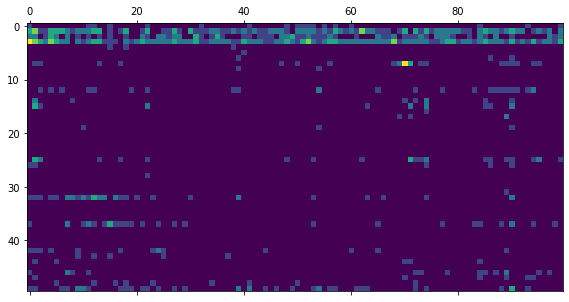

In [11]:
##Example raw neuron activity
# mouse_recday='me11_05122021_06122021'
session=0
Neuron_raw=np.load(Data_folder+'Neuron_raw_'+mouse_recday+'_'+str(session)+'.npy')
print(np.shape(Neuron_raw))
plt.matshow(Neuron_raw[:,:100])


In [17]:
mouse_recdays = ['bp01_24032024_25032024', 'bp01_28032024_31032024', 'bp01_21032024_23032024', 'bp01_02042024_03042024']
mouse_recday = mouse_recdays[1]
# for mouse_recday in mouse_recdays:
#     Tasks=np.load(Data_folder+'Task_data_'+mouse_recday+'.npy',allow_pickle=True)
#     print(Tasks)

for i in range(11):
    try:
        filename = f'{Data_folder}Tasks_{mouse_recday}_{i}.npy'
        print(filename)
        Tasks=np.load(filename,allow_pickle=True)
        print(Tasks)
    except FileNotFoundError:
        print(f"The file '{filename}' does not exist. Please check the file path and try again.")
    
        

Data/Tasks_bp01_28032024_31032024_0.npy
defaultdict(<function rec_dd at 0x7fd0cad8de18>, {})
Data/Tasks_bp01_28032024_31032024_1.npy
defaultdict(<function rec_dd at 0x7fd0cad8de18>, {})
Data/Tasks_bp01_28032024_31032024_2.npy
defaultdict(<function rec_dd at 0x7fd0cad8de18>, {})
Data/Tasks_bp01_28032024_31032024_3.npy
defaultdict(<function rec_dd at 0x7fd0cad8de18>, {})
Data/Tasks_bp01_28032024_31032024_4.npy
defaultdict(<function rec_dd at 0x7fd0cad8de18>, {})
Data/Tasks_bp01_28032024_31032024_5.npy
defaultdict(<function rec_dd at 0x7fd0cad8de18>, {})
Data/Tasks_bp01_28032024_31032024_6.npy
defaultdict(<function rec_dd at 0x7fd0cad8de18>, {})
Data/Tasks_bp01_28032024_31032024_7.npy
defaultdict(<function rec_dd at 0x7fd0cad8de18>, {})
Data/Tasks_bp01_28032024_31032024_8.npy
The file 'Data/Tasks_bp01_28032024_31032024_8.npy' does not exist. Please check the file path and try again.
Data/Tasks_bp01_28032024_31032024_9.npy
The file 'Data/Tasks_bp01_28032024_31032024_9.npy' does not exist. 

/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


bp01_24032024_25032024 session 3 does not exist
bp01_24032024_25032024 session 7 does not exist
bp01_24032024_25032024 session 9 does not exist
bp01_24032024_25032024 session 10 does not exist
bp01_24032024_25032024 session 11 does not exist
bp01_28032024_31032024 session 8 does not exist
bp01_28032024_31032024 session 9 does not exist
bp01_28032024_31032024 session 10 does not exist
bp01_28032024_31032024 session 11 does not exist
bp01_21032024_23032024 session 4 does not exist
bp01_21032024_23032024 session 6 does not exist
bp01_21032024_23032024 session 8 does not exist
bp01_21032024_23032024 session 10 does not exist
bp01_21032024_23032024 session 11 does not exist
_____
Example output neuron
trials x normalised time bins
dashed lines represent reward times


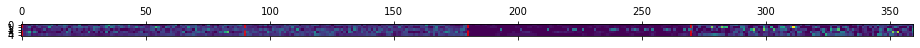

In [24]:
###Normalisation - i.e. how to get from array of raw firing rates and state times to
##normalised firing matrices

###Defining functions


###Example
mouse_recdays = ['bp01_24032024_25032024', 'bp01_28032024_31032024', 'bp01_21032024_23032024']
norm_neurons_dic = {}
session_inds_dic = {}
for mouse_recday in mouse_recdays:
    norm_neurons_list = []
    session_inds = []
    for session in range(12):
        try:
            Neuron_raw=np.load(Data_folder+'Neuron_raw_'+mouse_recday+'_'+str(session)+'.npy')
            Trial_times=np.load(Data_folder+'trialtimes_'+mouse_recday+'_'+str(session)+'.npy')
            num_trials=len(Trial_times)
            num_neurons=len(Neuron_raw)
            session_inds.append(session)


            ##Normalisation
            num_bins=90
            num_states=4
            num_phases=3

            Trial_times_conc=np.hstack((np.concatenate(Trial_times[:,:-1]),Trial_times[-1,-1]))//25
            Neurons_norm=np.zeros((num_neurons,num_trials,num_bins*num_states))
            Neurons_norm[:]=np.nan
            
            for neuron in np.arange(num_neurons):
                Neuron_raw_neuron=Neuron_raw[neuron,:]
                Neuron_raw_neuron_split=partition(list(Neuron_raw_neuron), list(Trial_times_conc))
                Neuron_raw_neuron_split_norm=np.asarray([normalise(Neuron_raw_neuron_split[ii])\
                                                        for ii in np.arange(len(Neuron_raw_neuron_split))])
                Neuron_norm=(Neuron_raw_neuron_split_norm.reshape(len(Neuron_raw_neuron_split_norm)//4,\
                                                                len(Neuron_raw_neuron_split_norm[0])*4))
                
                Neurons_norm[neuron]=Neuron_norm
           
            norm_neurons_list.append(Neurons_norm)
        except:
            print(f'{mouse_recday} session {session} does not exist')

    norm_neurons_dic[mouse_recday]=norm_neurons_list
    session_inds_dic[mouse_recday]=session_inds
    
print('_____')
print('Example output neuron')
print('trials x normalised time bins')
print('dashed lines represent reward times')
###plotting example
neuron=0
plt.matshow(Neurons_norm[neuron])
for angle in np.arange(4)*90:
    plt.axvline(angle,color='red',ls='dashed')
plt.show()

In [25]:
norm_neurons_dic['bp01_21032024_23032024'][0].shape

(40, 23, 360)

In [26]:
norm_neurons_dic['bp01_24032024_25032024'][0].shape

(50, 22, 360)

In [27]:
norm_neurons_dic['bp01_28032024_31032024'][0].shape

(26, 7, 360)

In [ ]:

for i in Neurons_norm:
    mean_neuron = np.mean(i, axis=0)
    mean_neuron = smooth_circ(mean_neuron)
    angles = np.linspace(0, 2 * np.pi, num=360, endpoint=False)

    # Step 3: Create the polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.plot(angles, mean_neuron, label="Mean Firing Rate")

    # Enhance plot aesthetics
    ax.set_theta_zero_location("N")  # Set zero at the top (North)
    ax.set_theta_direction(-1)       # Clockwise direction
    ax.set_title("Mean Firing Rates Across Trials")
    ax.legend()

    # Display the plot
  

In [29]:
from matplotlib.backends.backend_pdf import PdfPages
n_neurons = Neurons_norm.shape[0]

output_pdf_path = "/Users/AdamHarris/Desktop/neuron_polar_plots_multi_day.pdf"
with PdfPages(output_pdf_path) as pdf:
    for mouse_recday in mouse_recdays:
        n_neurons = norm_neurons_dic[mouse_recday][0].shape[0]
        for neuron_idx in range(n_neurons):
            n_sessions = len(session_inds_dic[mouse_recday])
            fig, axes = plt.subplots(
                1, n_sessions, 
                subplot_kw={'projection': 'polar'},
                figsize=(15, 5),
                constrained_layout=True
            )
            
            for session_idx, session_data in enumerate(norm_neurons_dic[mouse_recday]):
                # Extract data for the current neuron in the current session
                neuron_data = session_data[neuron_idx]
                
                # Compute the mean firing rate across trials
                mean_firing_rates = np.mean(neuron_data, axis=0)
                mean_firing_rates = smooth_circ(mean_firing_rates)
                
                # Define angles for the polar plot
                angles = np.linspace(0, 2 * np.pi, num=360, endpoint=False)
                
                # Plot for the current session
                ax = axes[session_idx]
                ax.plot(angles, mean_firing_rates, label=f"Session {session_idx + 1}")
                ax.set_theta_zero_location("N")
                ax.set_theta_direction(-1)
                ax.set_title(f"Session {session_idx + 1}", fontsize=10)
            
            # Set a global title for the neuron
            fig.suptitle(f"{mouse_recday}: Neuron {neuron_idx + 1}", fontsize=16)
            
            # Show the plot
            pdf.savefig(fig)
            plt.close(fig) 

/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


IndexError: index 40 is out of bounds for axis 0 with size 40

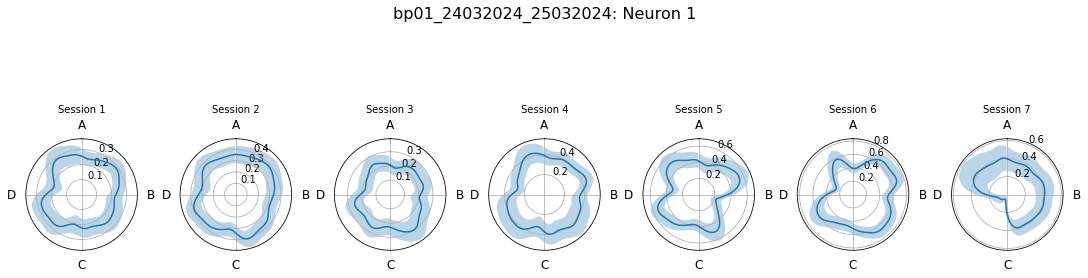

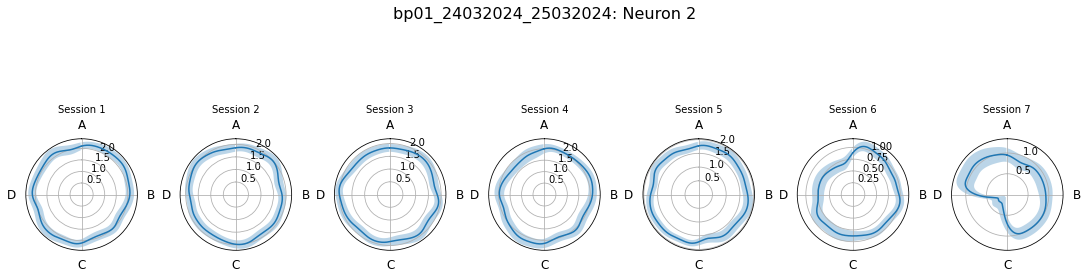

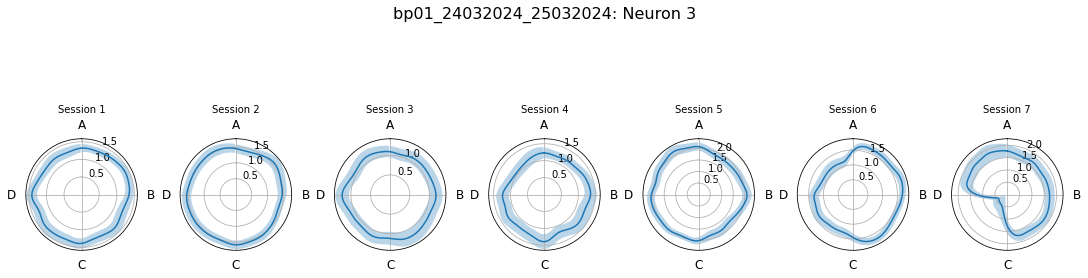

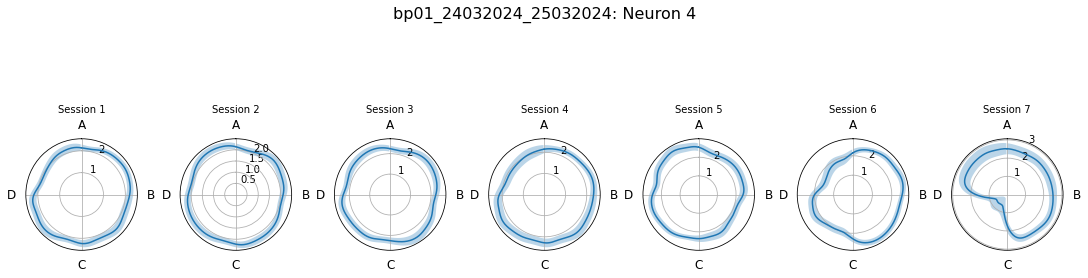

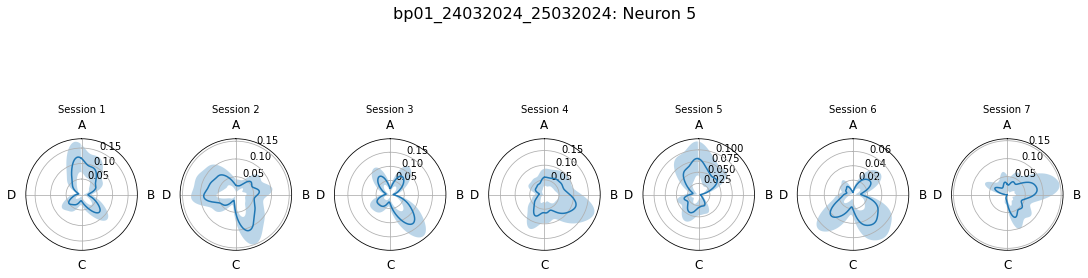

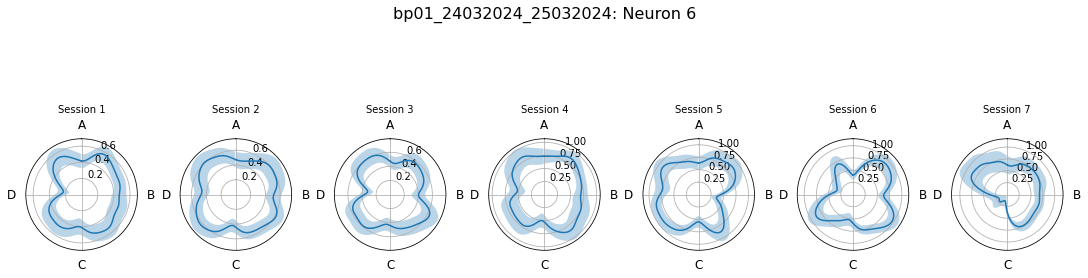

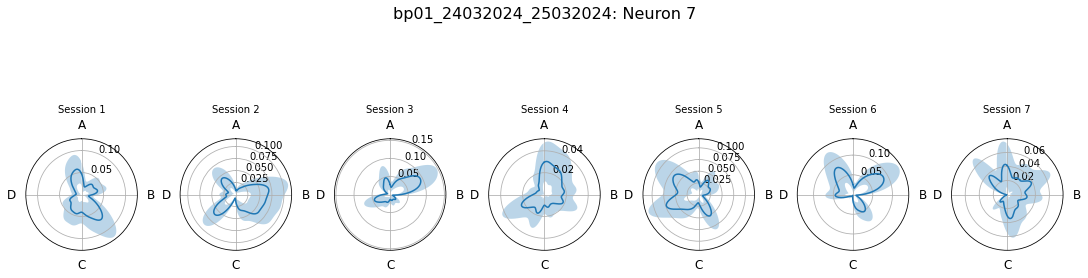

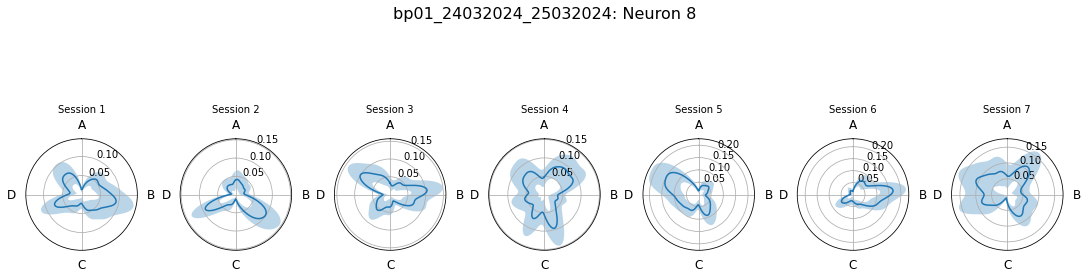

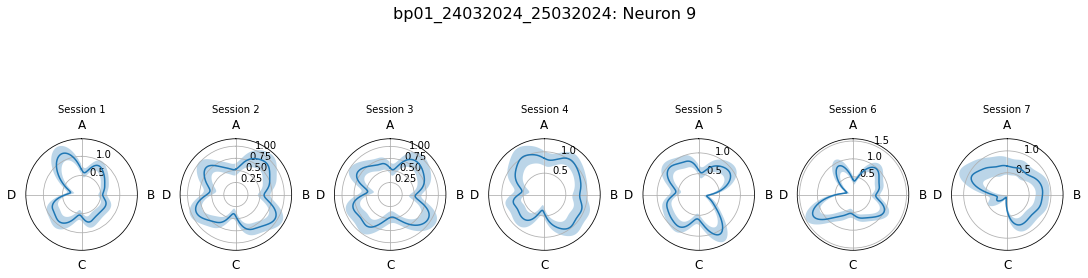

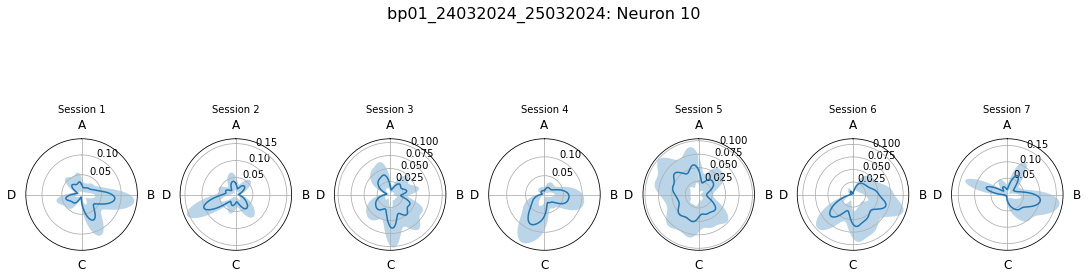

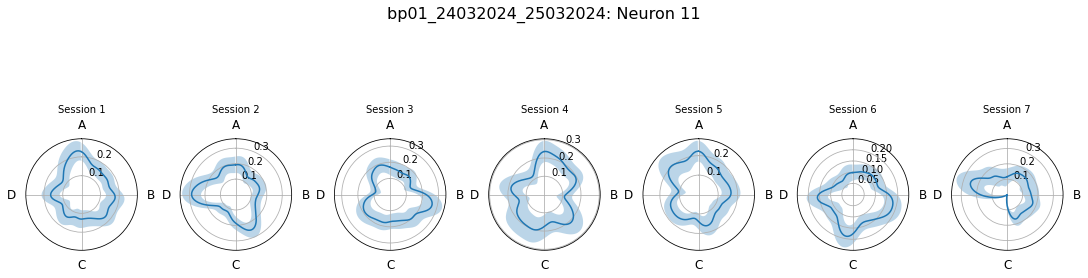

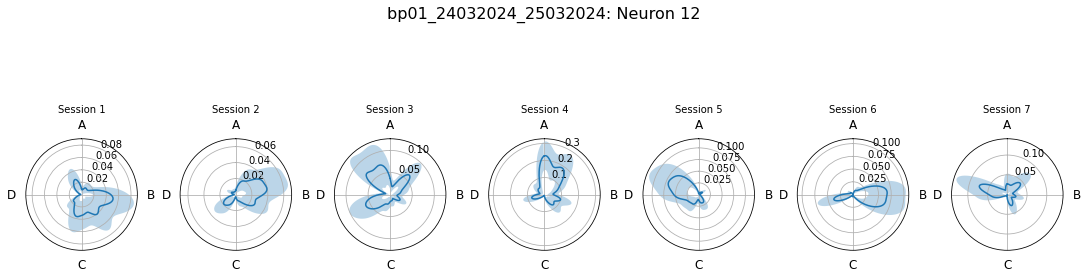

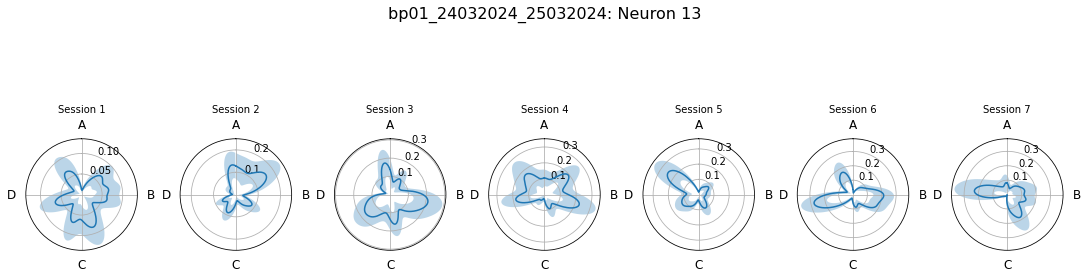

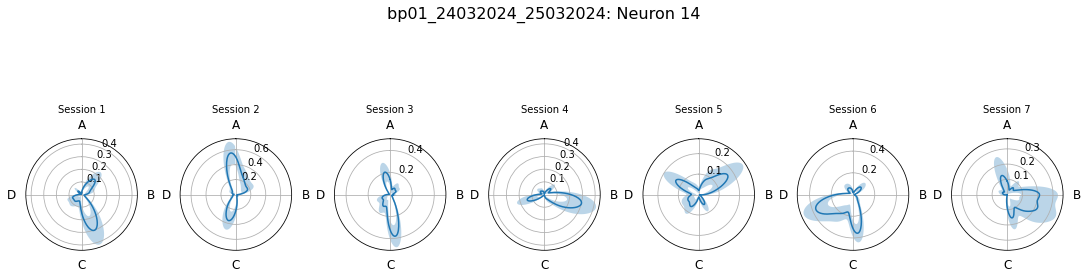

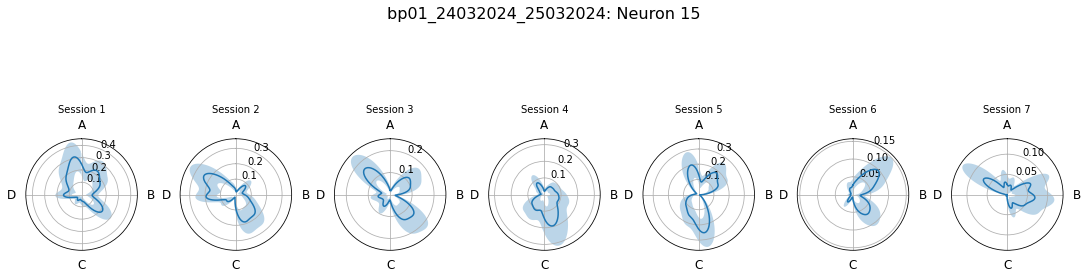

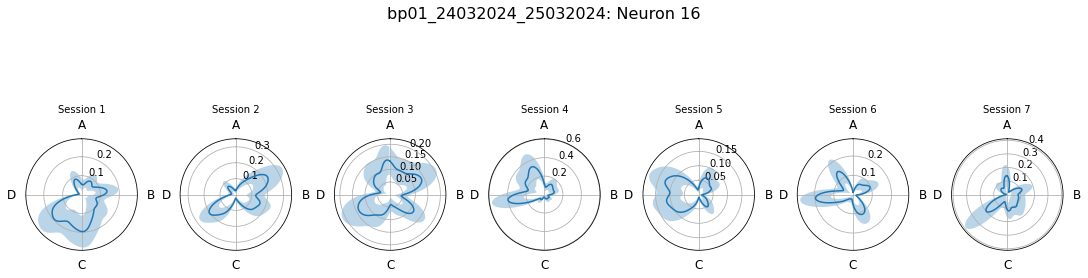

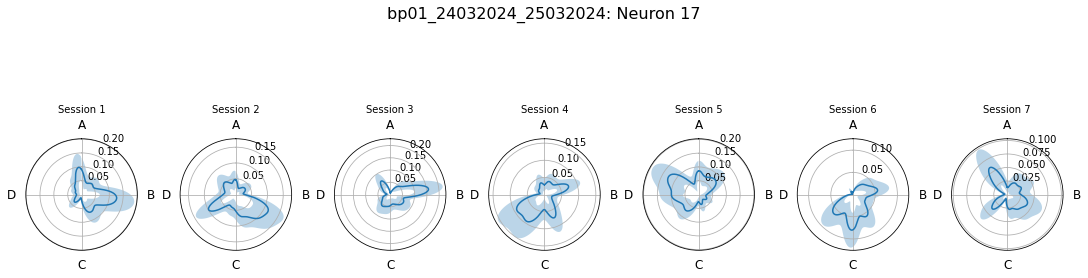

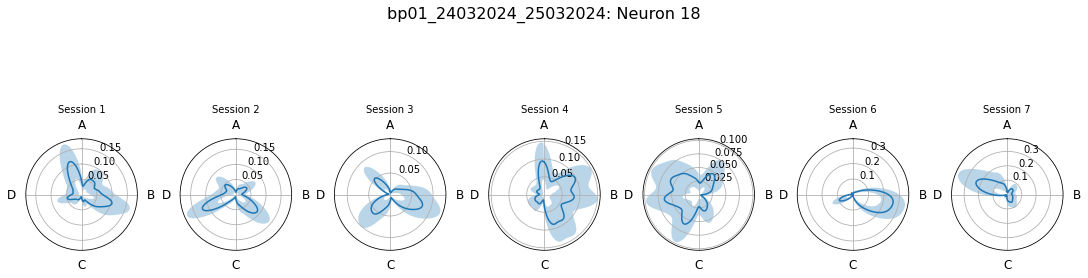

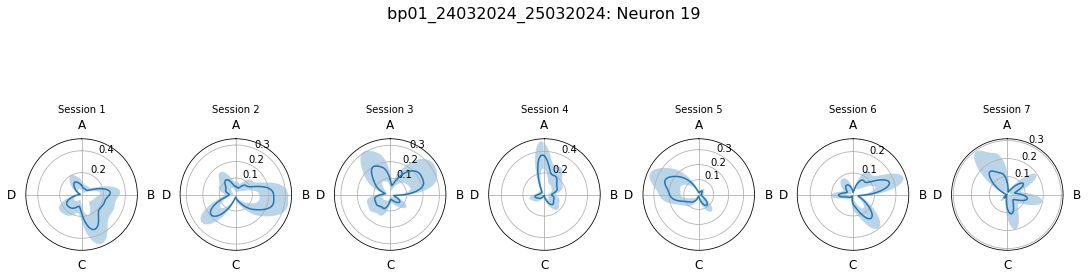

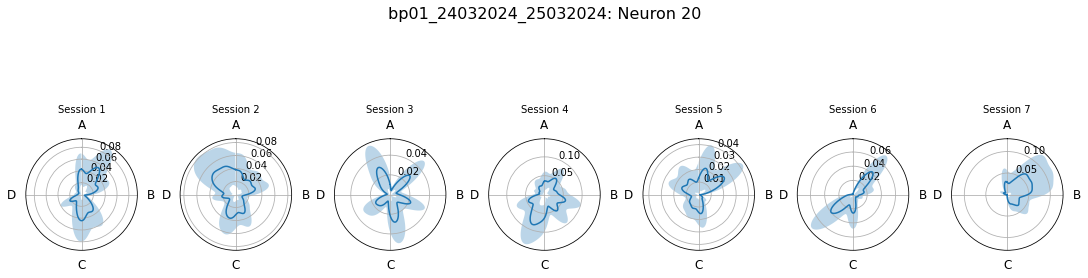

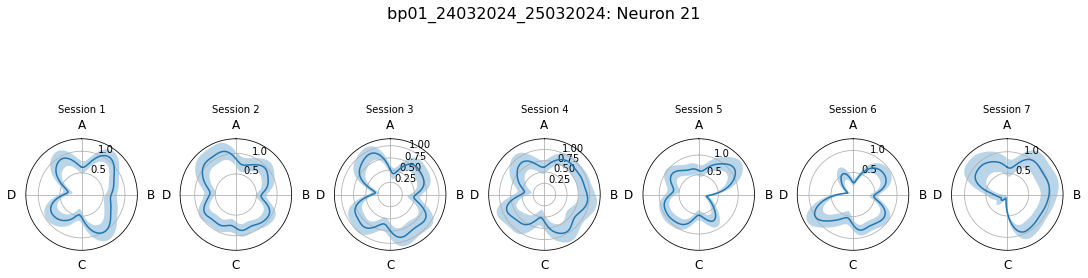

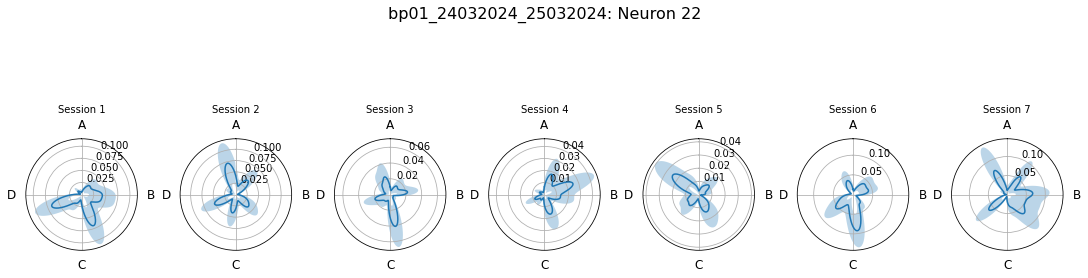

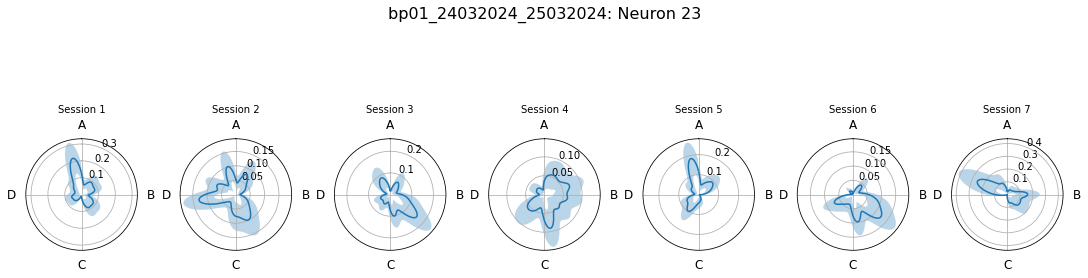

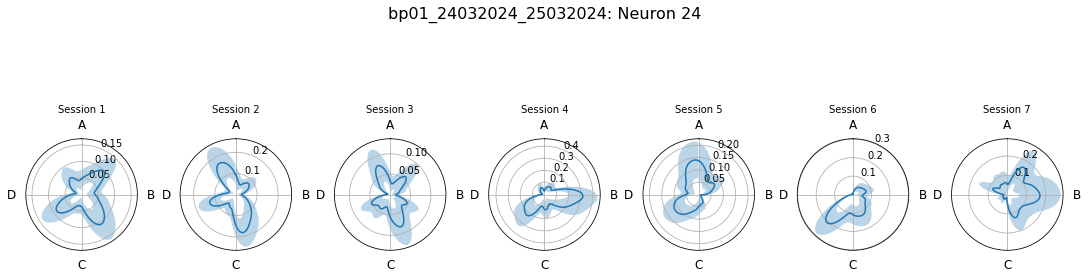

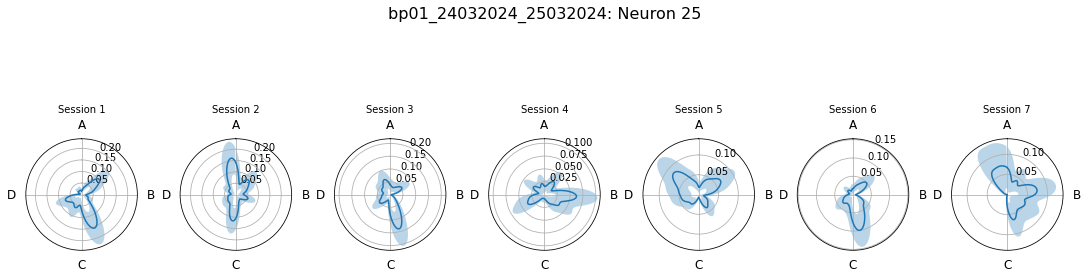

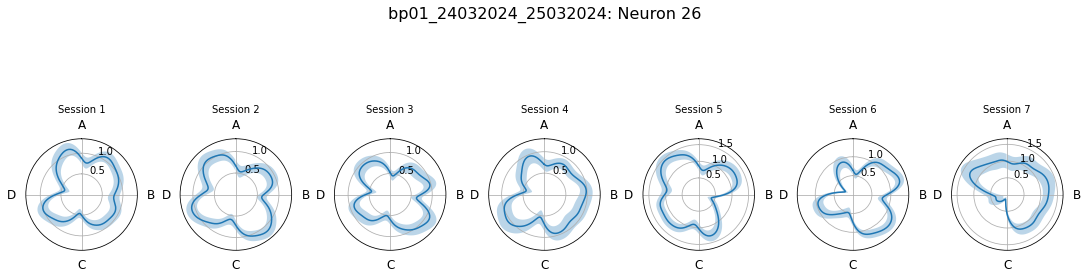

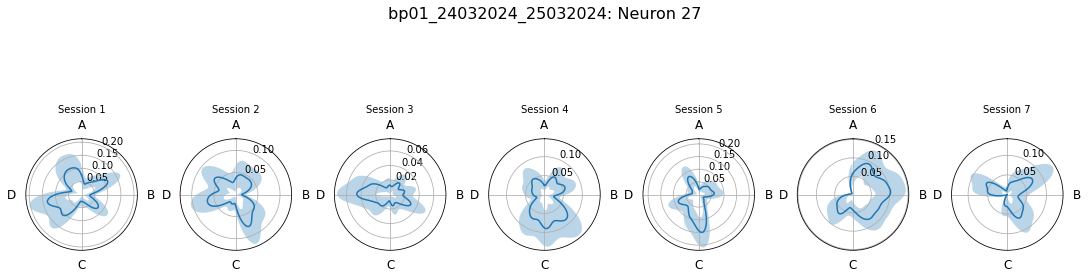

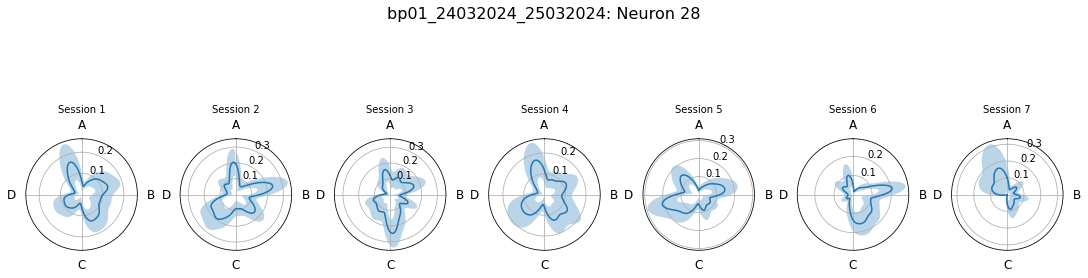

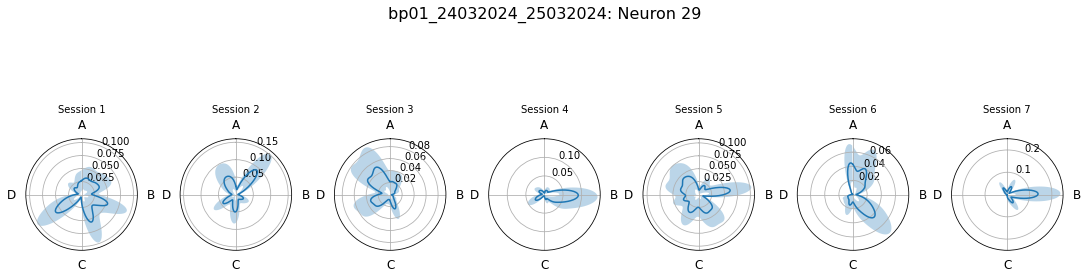

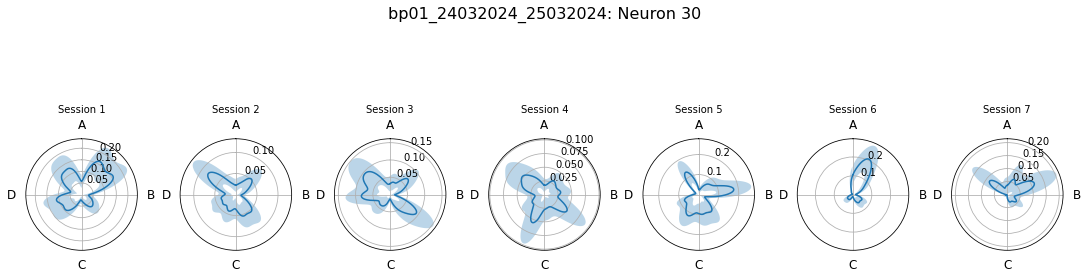

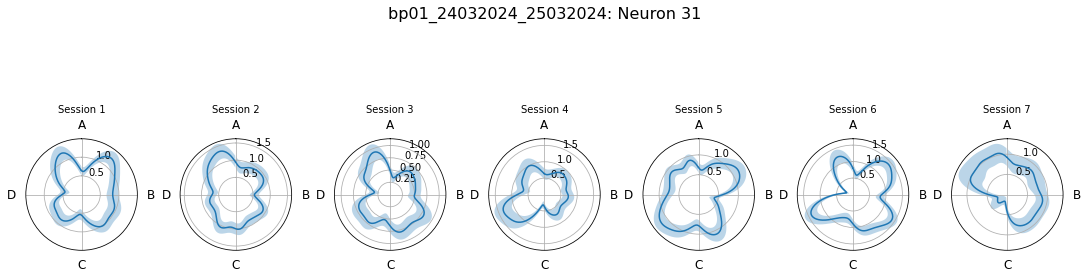

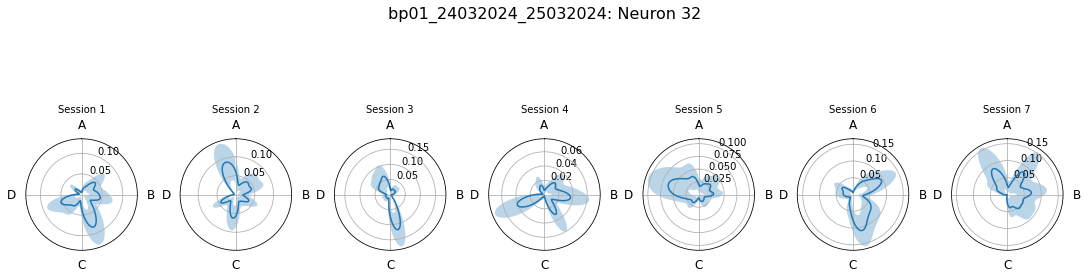

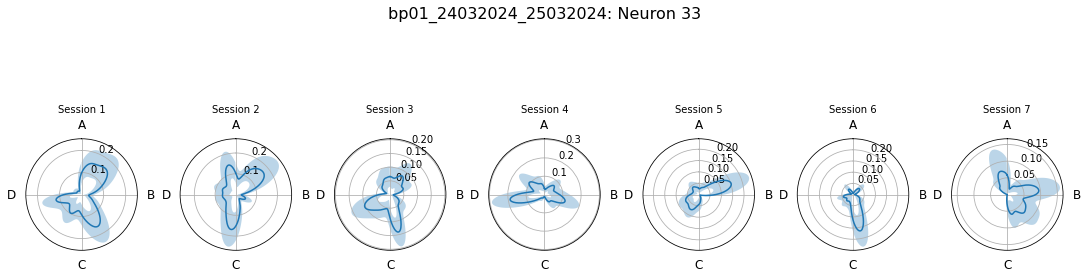

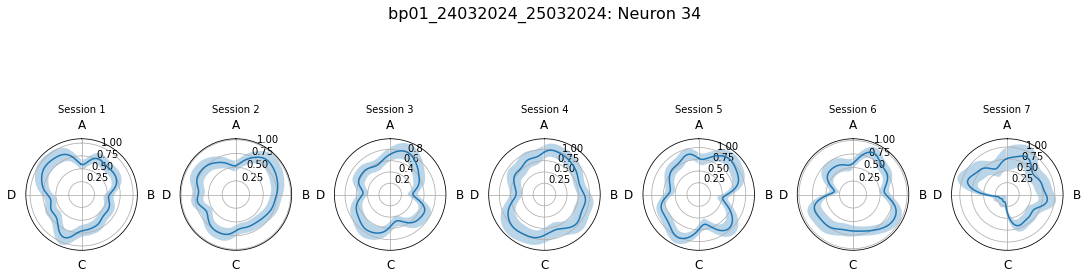

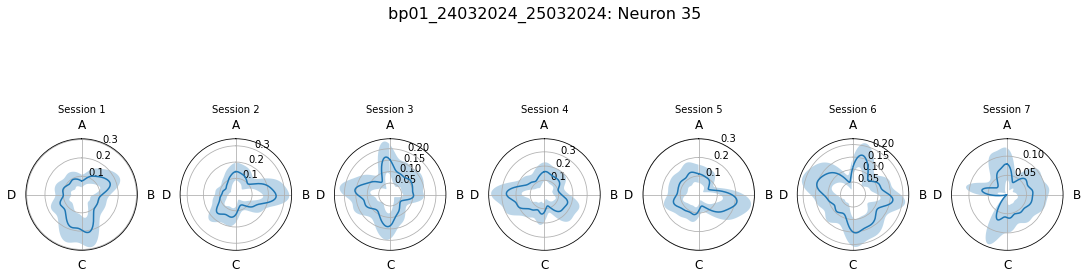

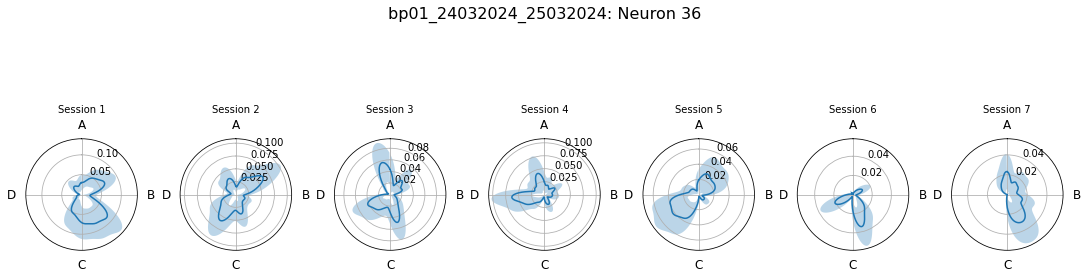

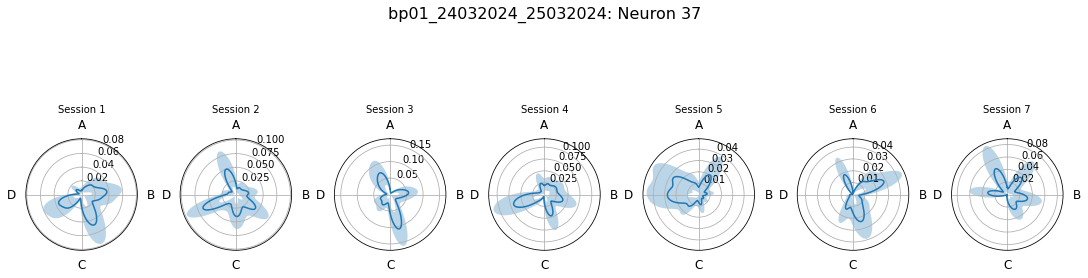

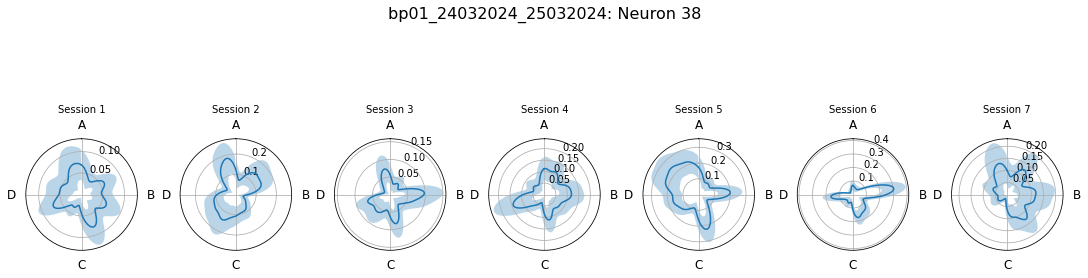

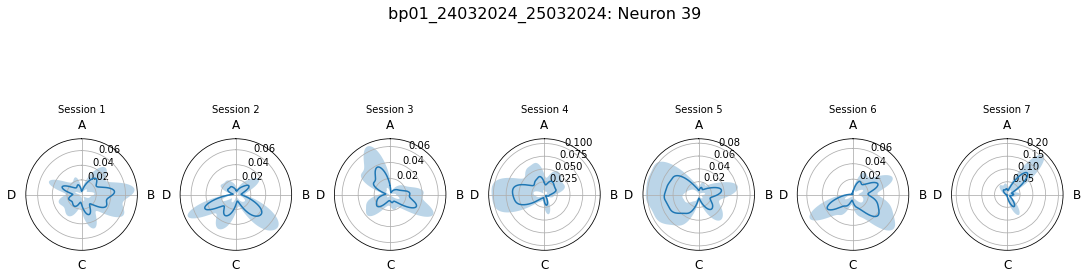

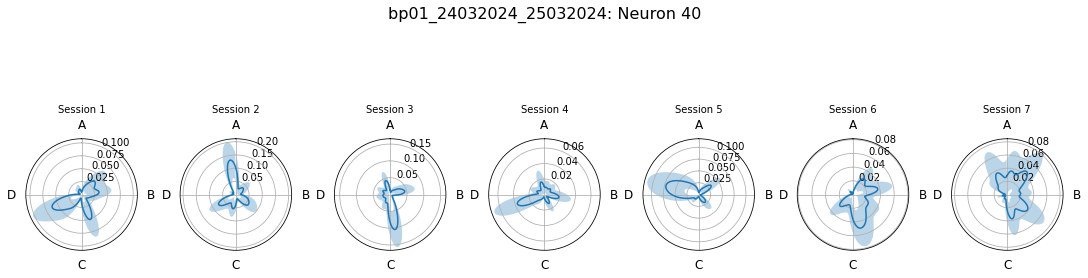

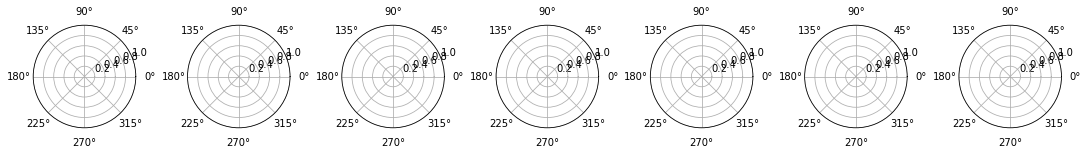

In [30]:
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import sem
n_neurons = Neurons_norm.shape[0]
sessions = [0,1,2,4,5,6,8]
n_sessions = len(sessions)
output_pdf_path = "/Users/AdamHarris/Desktop/neuron_polar_plots_mEC_multi-recday.pdf"
custom_labels = ["A", "B", "C", "D"]
with PdfPages(output_pdf_path) as pdf:
    for mouse_recday in mouse_recdays:
        n_neurons = norm_neurons_dic[mouse_recday][0].shape[0]
        for neuron_idx in range(n_neurons):
            fig, axes = plt.subplots(
                1, n_sessions, 
                subplot_kw={'projection': 'polar'},
                figsize=(15, 5),
                constrained_layout=True
            )
            
            for session_idx, session_data in enumerate(norm_neurons_list):
                # Extract data for the current neuron in the current session
                neuron_data = session_data[neuron_idx]
                std_err_neuron = std_err(neuron_data)
                # Compute the mean firing rate across trials
                mean_firing_rates = np.mean(neuron_data, axis=0)
                mean_firing_rates = smooth_circ(mean_firing_rates)
                
                # Define angles for the polar plot
                angles = np.linspace(0, 2 * np.pi, num=360, endpoint=False)
                
                # Plot for the current session
                ax = axes[session_idx]
                ax.plot(angles, mean_firing_rates, label=f"Session {session_idx + 1}")
                ax.fill(
                    np.concatenate([angles, angles[::-1]]),
                    np.concatenate([mean_firing_rates + std_err_neuron, (mean_firing_rates - std_err_neuron)[::-1]]),
                    alpha=0.3,
                    label=f"± SEM"
                )
                ax.set_theta_zero_location("N")
                ax.set_theta_direction(-1)
                ax.set_title(f"Session {session_idx + 1}", fontsize=10)
                # Customize the axis labels
                ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2])  # Positions: North, East, South, West
                ax.set_xticklabels(custom_labels, fontsize=12)
            
            # Set a global title for the neuron
            fig.suptitle(f"{mouse_recday}: Neuron {neuron_idx + 1}", fontsize=16)
            
            # Show the plot
            pdf.savefig(fig)
            # plt.close(fig) 

In [20]:
n_neurons = Neurons_norm.shape[0]
sessions = [0,1,2,4,5,6]

for neuron_idx in range(n_neurons):
    for session_idx, session_data in enumerate(norm_neurons_list[:-1]):
        # Extract data for the current neuron in the current session
        neuron_data = session_data[neuron_idx]
        std_err_neuron = std_err(neuron_data)
        # Compute the mean firing rate across trials
        mean_firing_rates = np.mean(neuron_data, axis=0)
        mean_firing_rates = smooth_circ(mean_firing_rates)
        
        # Define angles for the polar plot
        angles = np.linspace(0, 2 * np.pi, num=360, endpoint=False)
        
        # Plot for the current session
        ax = axes[session_idx]
        ax.plot(angles, mean_firing_rates, label=f"Session {session_idx + 1}")
        ax.fill(
            np.concatenate([angles, angles[::-1]]),
            np.concatenate([mean_firing_rates + std_err_neuron, (mean_firing_rates - std_err_neuron)[::-1]]),
            alpha=0.3,
            label=f"± SEM"
        )
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        ax.set_title(f"Session {session_idx + 1}", fontsize=10)
    
    # Set a global title for the neuron
    fig.suptitle(f"Neuron {neuron_idx + 1}", fontsize=16)
    
    # Show the plot
    # pdf.savefig(fig)
    # plt.close(fig) 

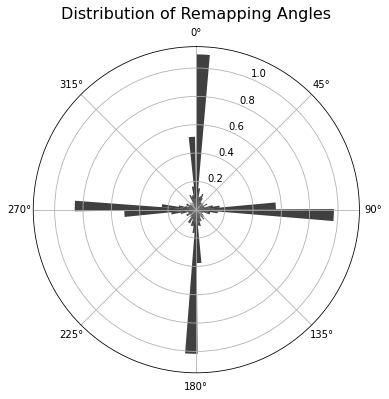

In [34]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Example data: list of sessions with 3D arrays (neurons x trials x timepoints)
# # Replace these with your actual data
# n_sessions = 4
# n_neurons = 5
# n_trials = 100
# n_timepoints = 360
# sessions = [np.random.rand(n_neurons, n_trials, n_timepoints) for _ in range(n_sessions)]

# # Compute mean firing rates for each neuron in each session
mean_firing_rates = [np.mean(arr, axis=1) for arr in norm_neurons_list]  # List of arrays (neurons x timepoints)
mean_fr_dic = {}
stderr_dic = {}
# # Function to compute remapping angles for a single neuron
def compute_remapping_angle(mean1, mean2):
    n_bins = len(mean1)
    angles = np.arange(n_bins) * (2 * np.pi / n_bins)  # Angles corresponding to each bin
    correlations = []
    for shift in range(n_bins):
        # Circularly shift mean1
        shifted_mean1 = np.roll(mean1, shift)
        # Compute correlation
        correlation = np.corrcoef(shifted_mean1, mean2)[0, 1]
        correlations.append(correlation)
    # Find the shift that maximizes the correlation
    best_shift = np.argmax(correlations)
    best_angle = angles[best_shift]
    return best_angle

# # Compute remapping angles for all neurons and pairs of sessions
remapping_angles = []

for mouse_recday in mouse_recdays:
    n_neurons = norm_neurons_dic[mouse_recday][0].shape[0]
    mean_firing_rates = [np.mean(arr, axis=1) for arr in norm_neurons_dic[mouse_recday]] 
    mean_fr_dic[mouse_recday] = mean_firing_rates
    for neuron_idx in range(n_neurons):
        for session1_idx in range(n_sessions-1):
            for session2_idx in range(session1_idx + 1, n_sessions-1):
                # Normalize the mean firing rates (subtract the mean)
                mean1 = mean_firing_rates[session1_idx][neuron_idx] - np.mean(mean_firing_rates[session1_idx][neuron_idx])
                mean2 = mean_firing_rates[session2_idx][neuron_idx] - np.mean(mean_firing_rates[session2_idx][neuron_idx])
                # Compute the remapping angle
                angle = compute_remapping_angle(mean1, mean2)
                remapping_angles.append(angle)

# Plot a polar histogram of remapping angles
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.hist(remapping_angles, bins=72, density=True, alpha=0.75, color='black')
ax.set_title("Distribution of Remapping Angles", va='bottom', fontsize=16)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.show()


In [22]:
"""
- z score 
- entropy and apply arbitrary threshold (one value per state)
- shuffles
- exclude state tuning


- correlation across tasks 
- single correlation value per cell
- distribution
"""

'\n- z score \n- entropy and apply arbitrary threshold (one value per state)\n- shuffles\n- exclude state tuning\n\n\n- correlation across tasks \n- single correlation value per cell\n- distribution\n'

In [ ]:
import numpy as np
from scipy.stats import zscore
from scipy.stats import entropy

# Function to compute entropy
def compute_entropy(distribution):
    # Normalize to create a probability distribution
    probabilities = distribution / np.sum(distribution)
    return entropy(probabilities)

# Function to perform permutation test
def permutation_test(original_entropy, firing_rate, n_permutations=1000):
    permuted_entropies = []
    for _ in range(n_permutations):
        shuffled_firing_rate = np.random.permutation(firing_rate)
        # Divide shuffled firing rate into 4 bins and compute average for each
        shuffled_binned = [
            np.mean(shuffled_firing_rate[i:i + 90])
            for i in range(0, len(shuffled_firing_rate), 90)
        ]
        permuted_entropies.append(compute_entropy(shuffled_binned))
    # Compare original entropy to the permuted distribution
    p_value = np.mean(original_entropy > np.array(permuted_entropies))
    return p_value

# Parameters for permutation test
n_permutations = 1000
significance_threshold = 0.05

sig_neurons_dic = {}
# Analyze each neuron


for mouse_recday in mouse_recdays:
    n_neurons = norm_neurons_dic[mouse_recday][0].shape[0]
    significant_neurons = []  # Store indices of neurons that pass the test
    for neuron_idx in range(n_neurons):
        for session_idx, session_data in enumerate(sessions):
            # Step 1: Compute mean firing rate across trials
            mean_firing_rate = mean_fr_dic[mouse_recday][session_idx][neuron_idx]

            # Step 2: Z-score the mean firing rate
            zscored_firing_rate = zscore(mean_firing_rate)

            # Step 3: Divide into 4 bins and compute average for each bin
            binned_firing_rate = [
                np.mean(zscored_firing_rate[i:i + 90])
                for i in range(0, len(zscored_firing_rate), 90)
            ]

            # Step 4: Calculate entropy of the binned distribution
            neuron_entropy = compute_entropy(binned_firing_rate)

            # Step 5: Perform permutation test
            p_value = permutation_test(neuron_entropy, zscored_firing_rate, n_permutations)

            # Step 6: Check significance
            if p_value < significance_threshold:
                significant_neurons.append((session_idx, neuron_idx))
    sig_neurons_dic[mouse_recday] = significant_neurons


# Output results
print(f"Significant neurons (session_idx, neuron_idx): {significant_neurons}")


/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2544: RuntimeWarning: divide by zero encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


KeyboardInterrupt: 

In [26]:
mean_firing_rate

array([0.12588102, 0.06041851, 0.148659  , 0.24110602, 0.11373416,
       0.23182813, 0.04065934, 0.17208653, 0.12197592, 0.0952002 ,
       0.14242175, 0.09671172, 0.16440571, 0.11565408, 0.12965617,
       0.1653783 , 0.2270936 , 0.07999242, 0.11087801, 0.0773399 ,
       0.14501284, 0.10231627, 0.08724264, 0.04813271, 0.06661193,
       0.1276264 , 0.17615679, 0.21967707, 0.08720705, 0.24770115,
       0.18004716, 0.13866785, 0.28437827, 0.16266684, 0.16472149,
       0.1954023 , 0.17269818, 0.21668982, 0.28825944, 0.23635866,
       0.15544609, 0.13319439, 0.26160162, 0.31891078, 0.29077513,
       0.29151194, 0.2955043 , 0.27736516, 0.33617953, 0.22255063,
       0.16378105, 0.1227422 , 0.17547893, 0.31951076, 0.24649948,
       0.16803503, 0.24612858, 0.18023088, 0.25399352, 0.25032841,
       0.26918025, 0.2290893 , 0.32536946, 0.22399478, 0.34559004,
       0.36642036, 0.32452107, 0.33401541, 0.34656665, 0.17541998,
       0.32816092, 0.1532567 , 0.25983978, 0.28218391, 0.29885

[0.2602667414347604, 0.2357531874995643, 0.2488999989543468, 0.24747041605737258]
1.3856815947466068
_____________
[0.3674791869609797, 0.360111928048436, 0.353584369774846, 0.3384325073556053]
1.3858372159421752
_____________
[0.22080175070156857, 0.2524857521644014, 0.24698378569068222, 0.21023266171414323]
1.3834155503145436
_____________
[0.397989244683633, 0.3959147795155859, 0.38500949667616335, 0.34757754709641014]
1.3848588665762627
_____________
[0.4614537989017157, 0.3509309964726632, 0.46016600142331143, 0.43587171573282685]
1.3804879688705247
_____________
[0.5908704525389348, 0.6012937251430353, 0.5342062230179513, 0.396792328042328]
1.3738943649129447
_____________
[0.3858863856175684, 0.4064158103718084, 0.0750537037037037, 0.3954318629808827]
1.2585152295738058
_____________
[2.160708778430579, 1.9660221155655935, 2.1101677227764184, 2.0786844717279496]
1.3856997638670276
_____________
[1.898001628260732, 1.8960177454820308, 1.8650683135206947, 1.914922380777608]
1.3862

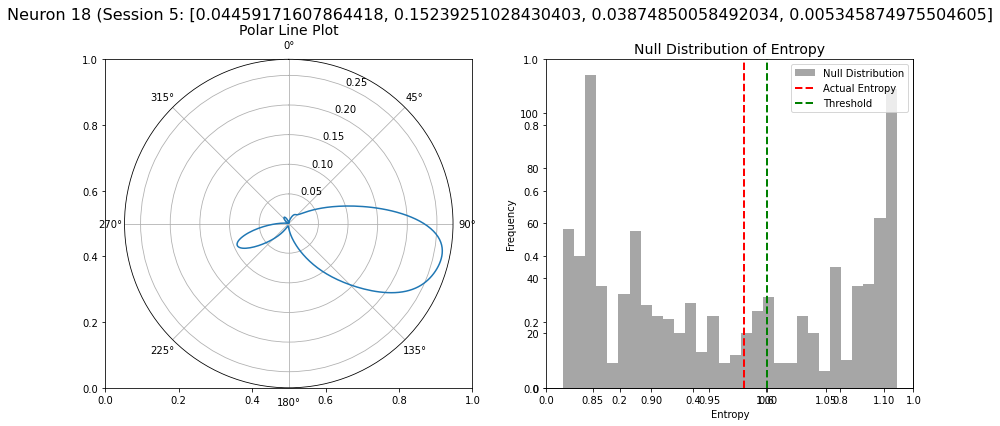

[0.2602667414347604, 0.2357531874995643, 0.2488999989543468, 0.24747041605737258]
1.3856815947466068
_____________
[0.3674791869609797, 0.360111928048436, 0.353584369774846, 0.3384325073556053]
1.3858372159421752
_____________
[0.22080175070156857, 0.2524857521644014, 0.24698378569068222, 0.21023266171414323]
1.3834155503145436
_____________
[0.397989244683633, 0.3959147795155859, 0.38500949667616335, 0.34757754709641014]
1.3848588665762627
_____________
[0.4614537989017157, 0.3509309964726632, 0.46016600142331143, 0.43587171573282685]
1.3804879688705247
_____________
[0.5908704525389348, 0.6012937251430353, 0.5342062230179513, 0.396792328042328]
1.3738943649129447
_____________
[0.3858863856175684, 0.4064158103718084, 0.0750537037037037, 0.3954318629808827]
1.2585152295738058
_____________
[2.160708778430579, 1.9660221155655935, 2.1101677227764184, 2.0786844717279496]
1.3856997638670276
_____________
[1.898001628260732, 1.8960177454820308, 1.8650683135206947, 1.914922380777608]
1.3862

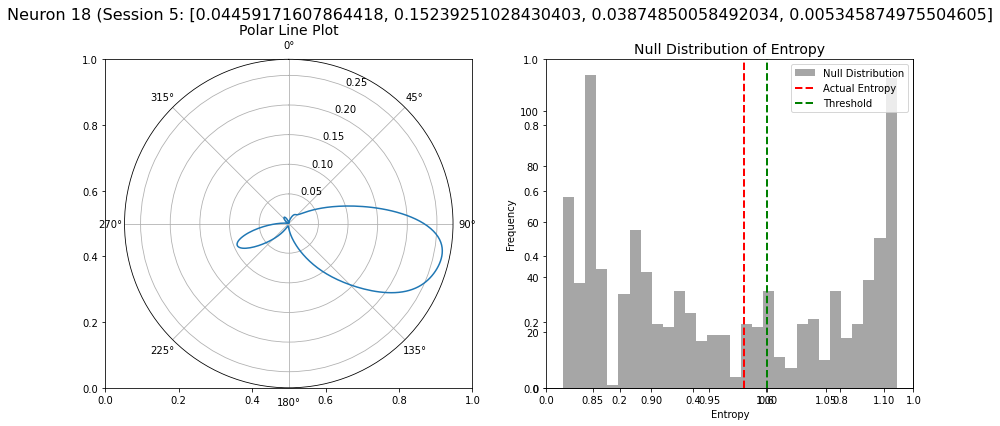

[0.2602667414347604, 0.2357531874995643, 0.2488999989543468, 0.24747041605737258]
1.3856815947466068
_____________
[0.3674791869609797, 0.360111928048436, 0.353584369774846, 0.3384325073556053]
1.3858372159421752
_____________
[0.22080175070156857, 0.2524857521644014, 0.24698378569068222, 0.21023266171414323]
1.3834155503145436
_____________
[0.397989244683633, 0.3959147795155859, 0.38500949667616335, 0.34757754709641014]
1.3848588665762627
_____________
[0.4614537989017157, 0.3509309964726632, 0.46016600142331143, 0.43587171573282685]
1.3804879688705247
_____________
[0.5908704525389348, 0.6012937251430353, 0.5342062230179513, 0.396792328042328]
1.3738943649129447
_____________
[0.3858863856175684, 0.4064158103718084, 0.0750537037037037, 0.3954318629808827]
1.2585152295738058
_____________
[2.160708778430579, 1.9660221155655935, 2.1101677227764184, 2.0786844717279496]
1.3856997638670276
_____________
[1.898001628260732, 1.8960177454820308, 1.8650683135206947, 1.914922380777608]
1.3862

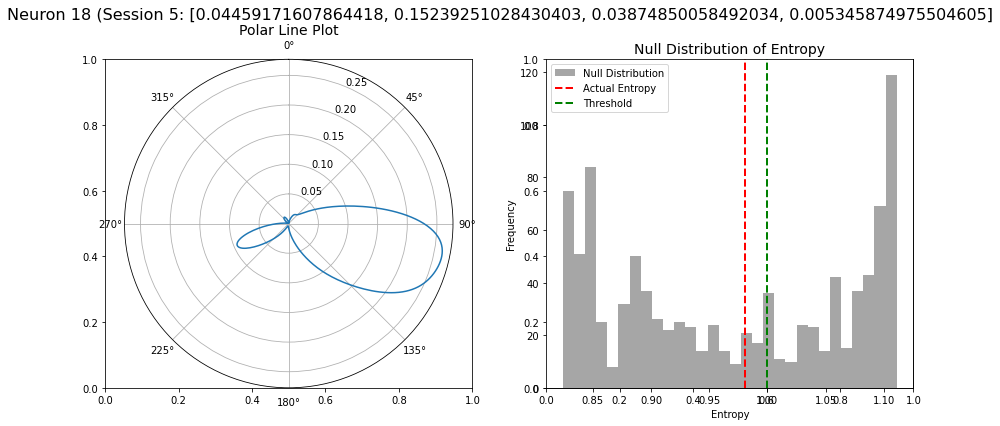

In [36]:


# Function to compute entropy
def compute_entropy(distribution):
    probabilities = distribution / np.sum(distribution)  # Normalize to probabilities
    return entropy(probabilities)

# Function to perform permutation test and return null distribution
def permutation_test_with_visualization(original_entropy, session_data_whole, n_permutations=1000):
    permuted_entropies = []
    num_trials = session_data_whole.shape[0]
    num_bins = session_data_whole.shape[1]
    session_data_whole = session_data_whole.flatten()
    for _ in range(n_permutations):
        shift = np.random.randint(0,len(session_data_whole)-1)

        shuffled_firing_rate = np.roll(session_data_whole, shift)
        shuffled_firing_rate = np.mean(shuffled_firing_rate.reshape(num_trials, num_bins), axis=0)
        shuffled_firing_rate = shuffled_firing_rate/max(shuffled_firing_rate)
        # Divide shuffled firing rate into 4 bins and compute average for each
        shuffled_binned = [
            np.mean(shuffled_firing_rate[i:i + 90])
            for i in range(0, len(shuffled_firing_rate), 90)
        ]
        permuted_entropies.append(compute_entropy(shuffled_binned))
    # Return null distribution
    return permuted_entropies

# Parameters for permutation test
n_permutations = 1000
significance_threshold = 0.05
n_timepoints = 360
results_dic = {}
entropies_dic = {}
sig_neurons_dic={}
# Analyze each neuron
for mouse_recday in mouse_recdays:  
    significant_neurons = []  # Store indices of neurons that pass the test
    results = []  # Store data for visualization
    entropies = []
    binned_FRs = {}
    for neuron_idx in range(n_neurons):
        for session_idx, session_data in enumerate(sessions):
            # Step 1: Compute mean firing rate across trials
            
            session_data_whole = norm_neurons_list[session_idx][neuron_idx]
            mean_firing_rate = np.mean(session_data_whole, axis=0)
            # Step 2: Z-score the mean firing rate
            norm_firing_rate = mean_firing_rate

            # Step 3: Divide into 4 bins and compute average for each bin
            binned_firing_rate = [
                np.mean(norm_firing_rate[i:i + 90])
                for i in range(0, len(norm_firing_rate), 90)
            ]
            binned_FRs[f"neuron_{neuron_idx}-session{session_idx}"]=binned_firing_rate
            print(binned_firing_rate)
            # Step 4: Calculate entropy of the binned distribution
            neuron_entropy = compute_entropy(binned_firing_rate/sum(binned_firing_rate))
            entropies.append(neuron_entropy)
            print(neuron_entropy)
            print('_____________')
            # Step 5: Perform permutation test
            null_entropies = permutation_test_with_visualization(
                neuron_entropy, session_data_whole, n_permutations
            )
            # Calculate p-value
            p_value = np.mean(neuron_entropy > np.array(null_entropies))
            threshold_entropy = 1.35 # np.percentile(null_entropies, 5)  # 5th percentile

            significant = neuron_entropy < threshold_entropy  # Check for significance < threshold_entropy  # Check for significance
            # Step 6: Check significance
            if significant:
                significant_neurons.append((session_idx, neuron_idx))
                results.append({
                    "session_idx": session_idx,
                    "neuron_idx": neuron_idx,
                    "mean_firing_rate": mean_firing_rate,
                    "angles": np.linspace(0, 2 * np.pi, num=n_timepoints, endpoint=False),
                    "entropy": neuron_entropy,
                    "null_entropies": null_entropies,
                    "threshold_entropy": threshold_entropy
                })
    sig_neurons_dic[mouse_recday] = significant_neurons
    # Visualization
    for result in results:
        session_idx = result["session_idx"]
        neuron_idx = result["neuron_idx"]
        mean_firing_rate = result["mean_firing_rate"]
        angles = result["angles"]
        entropy_val = result["entropy"]
        null_entropies = np.array(result["null_entropies"])  # Convert to NumPy array for processing
        threshold_entropy = result["threshold_entropy"]

        fr_data = norm_neurons_list[session_idx][neuron_idx]
        std_err_neuron = std_err(fr_data)
                # Compute the mean firing rate across trials
        mean_firing_rates = np.mean(fr_data, axis=0)
        mean_firing_rates = smooth_circ(mean_firing_rates)
        # Filter invalid values from null_entropies
        valid_null_entropies = null_entropies[np.isfinite(null_entropies)]

        # Plotting
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Plot 1: Polar line plot of mean firing rate
        ax1 = fig.add_subplot(121, projection="polar")
        ax1.plot(angles, mean_firing_rates, label=f"Neuron {neuron_idx} (Session {session_idx})")
        ax1.set_title("Polar Line Plot", fontsize=14)
        ax1.set_theta_zero_location("N")
        ax1.set_theta_direction(-1)

        # Plot 2: Null distribution of entropy
        ax2 = fig.add_subplot(122)
        if valid_null_entropies.size > 0:  # Check if there are valid values
            ax2.hist(valid_null_entropies, bins=30, alpha=0.7, color="grey", label="Null Distribution")
            ax2.axvline(entropy_val, color="red", linestyle="--", linewidth=2, label="Actual Entropy")
            ax2.axvline(threshold_entropy, color="green", linestyle="--", linewidth=2, label="Threshold")
            ax2.set_title("Null Distribution of Entropy", fontsize=14)
            ax2.set_xlabel("Entropy")
            ax2.set_ylabel("Frequency")
            ax2.legend()
        else:
            ax2.text(0.5, 0.5, "No valid null entropies", fontsize=14, ha='center')
        rates = binned_FRs[f"neuron_{neuron_idx}-session{session_idx}"]
        plt.suptitle(f"Neuron {neuron_idx+1} (Session {session_idx}: {rates}", fontsize=16)
        plt.tight_layout()
        plt.show()


<AxesSubplot:ylabel='Count'>

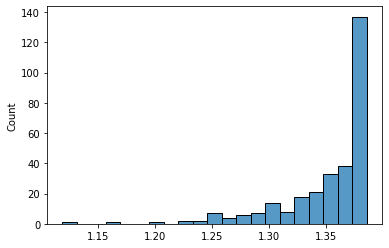

In [28]:

sns.histplot(entropies)

In [29]:
sig_neurons = []
for x in results:
    sig_neurons.append(x['neuron_idx'])
sig_neurons = list(set(sig_neurons))
sig_neurons.sort()


In [30]:
print(len(sig_neurons))

32



[[ 1.78030303e-02  4.63530655e-02  6.07505285e-02  2.55050505e-02
   3.18181818e-02  3.60546430e-02  1.37420719e-04  2.32177590e-02
   1.36363636e-02  1.05708245e-03  5.98484848e-02 -3.50951374e-03
   1.74440288e-02 -2.04231040e-02 -2.76838149e-02 -1.33333333e-02
  -9.39393939e-03 -4.46736597e-02  3.42678484e-02 -2.51433837e-02
  -3.70337995e-02  1.61183261e-02  1.82070707e-02 -2.61363636e-02
   8.07851240e-03 -1.79545455e-02 -2.36363636e-02 -2.10243632e-02
   1.52121212e-02  2.41620627e-02  4.13694639e-02  3.43023643e-03
  -6.42424242e-02 -2.37494444e-02  3.43234672e-03 -1.64883721e-02
   9.72995067e-02  2.30230880e-02  1.53515152e-01  3.88311688e-02
  -5.36089668e-02  1.58039519e-01  1.08251586e-01 -5.60000000e-02
  -6.48837209e-03  7.82365154e-02 -1.55505051e-02 -4.17775558e-02
  -1.66787102e-02  4.23374656e-02 -1.81994362e-02 -1.83227625e-04
  -3.45705122e-02  9.14202309e-02 -3.92963354e-02 -3.32064834e-03
   3.69823820e-02  3.03168044e-02 -1.66504039e-02 -1.47424242e-01
  -3.1947

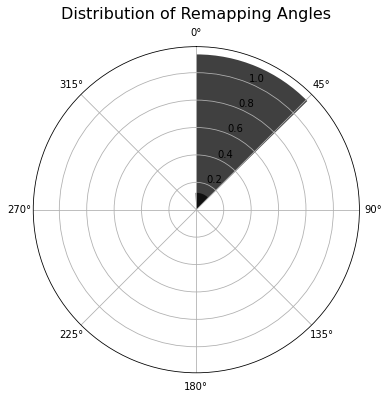

In [61]:

# # Function to compute remapping angles for a single neuron
def compute_remapping_angle(mean1, mean2):
    n_bins = len(mean1)
    angles = np.arange(n_bins) * (2 * np.pi / n_bins)  # Angles corresponding to each bin
    correlations = []
    for shift in range(n_bins):
        # Circularly shift mean1
        shifted_mean1 = np.roll(mean1, shift)
        # Compute correlation
        correlation = np.corrcoef(shifted_mean1, mean2)[0, 1]
        correlations.append(correlation)
    # Find the shift that maximizes the correlation
    best_shift = np.argmax(correlations)
    best_angle = angles[best_shift]
    return best_shift

# # Compute remapping angles for all neurons and pairs of sessions
remapping_angles = []
for mouse_recday in mouse_recdays:
    sig_neurons = sig_neurons_dic[mouse_recday]
    n_sessions = len(mean_fr_dic[mouse_recday])
    for neuron_idx in sig_neurons:
        print()
        for session1_idx in range(n_sessions-1):
            for session2_idx in range(session1_idx + 1, n_sessions-1):
                mean1 = mean_fr_dic[mouse_recday][session1_idx][neuron_idx,:]
                
                mean2 = mean_fr_dic[mouse_recday][session2_idx][neuron_idx,:]
                
                print(mean1-mean2)         
                # Normalize the mean firing rates (subtract the mean)
                # Compute the remapping angle
                angle = compute_remapping_angle(mean1, mean2)

                remapping_angles.append(angle)

# Plot a polar histogram of remapping angles
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.hist(np.rad2deg(remapping_angles), bins=72, density=True, alpha=0.75, color='black')
ax.set_title("Distribution of Remapping Angles", va='bottom', fontsize=16)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.show()


In [57]:
remapping_angles

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [52]:
mean_fr_dic[mouse_recday][0].shape

(50, 360)

In [44]:
norm_neurons_dic[mouse_recday][0][0].shape

(22, 360)

Bin counts: [136 115 112 117]
Observed Frequencies: [136 115 112 117]
Expected Frequencies: [120 120 120 120]
Chi-squared Value: 1.4202197312332254
P-value: 0.7008020336749814


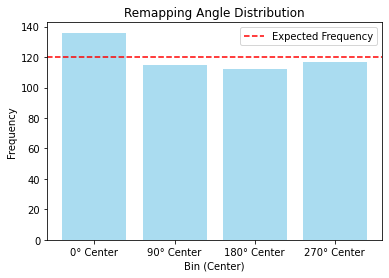

In [34]:
from scipy.stats import chi2_contingency


# Step 1: Define the remapping angles in degrees (assuming you've already converted them)
# Example remapping angles (replace with your actual data)
# Step 2: Rotate the angles by 45 degrees and wrap them into the 0-360 range
rotated_angles = (np.degrees(remapping_angles) + 45) % 360

# Step 3: Define bin edges for 4 bins: 0-90, 90-180, 180-270, 270-360
bin_edges = np.array([0, 90, 180, 270, 360])
bin_labels = ["0° Center", "90° Center", "180° Center", "270° Center"]
# Step 4: Use np.digitize to assign each rotated angle to a bin
bins = np.digitize(rotated_angles, bins=bin_edges, right=False)

# Step 5: Adjust the bin numbers (the digitize function returns bin indices starting from 1)
bins = bins - 1  # Adjust to make bin indices start from 0

# Step 6: Calculate frequencies of remapping angles in each bin
observed_frequencies = np.bincount(bins, minlength=4)

# Output the results
print("Bin counts:", observed_frequencies)

# Step 6: Expected frequencies (uniform distribution)
expected_frequencies = np.full_like(observed_frequencies, len(rotated_angles) / 4)

# Step 7: Perform chi-squared test
chi2, p_value = chi2_contingency([observed_frequencies, expected_frequencies])[:2]

# Step 8: Print results
print(f"Observed Frequencies: {observed_frequencies}")
print(f"Expected Frequencies: {expected_frequencies}")
print(f"Chi-squared Value: {chi2}")
print(f"P-value: {p_value}")



plt.bar(bin_labels, observed_frequencies, color="skyblue", alpha=0.7)
plt.axhline(y=expected_frequencies[0], color="red", linestyle="--", label="Expected Frequency")
plt.xlabel("Bin (Center)")
plt.ylabel("Frequency")
plt.title("Remapping Angle Distribution")
plt.legend()
plt.show()


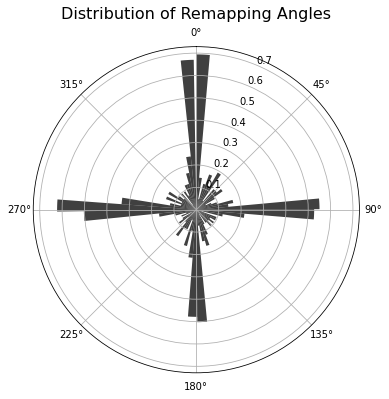

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.hist(remapping_angles, bins=72, density=True, alpha=0.75, color='black')
ax.set_title("Distribution of Remapping Angles", va='bottom', fontsize=16)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.savefig('/Users/AdamHarris/Desktop/remapping_angles.pdf', dpi=300) 

[(5, 17)]
[(5, 17)]
[(5, 17)]


/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/AdamHarris/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


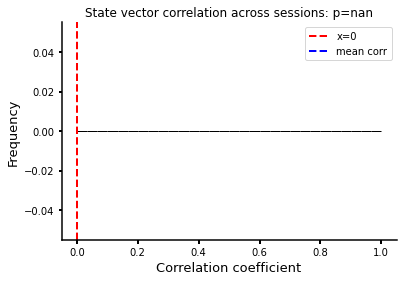

In [68]:
from scipy import stats

total_sessions = list(range(6))
all_neuron_correlations=[]
for mouse_recday in mouse_recdays:
    sig_neurons = sig_neurons_dic[mouse_recday]
    for neuron_idx in sig_neurons:
        print(sig_neurons)
        corrs = []
        for session1_idx in range(n_sessions-1):
            for session2_idx in range(session1_idx + 1, n_sessions-1):
            
                mean_firing_rate1 = mean_fr_dic[mouse_recday][session1_idx][neuron_idx, :]
                # Step 2: Z-score the mean firing rate

                mean_firing_rate2 = mean_fr_dic[mouse_recday][session2_idx][neuron_idx, :]
                # Step 2: Z-score the mean firing rate


                # Step 3: Divide into 4 bins and compute average for each bin
                binned_firing_rate1 = [
                    np.mean(norm_firing_rate1[i:i + 90])
                    for i in range(0, len(norm_firing_rate1), 90)
                ]

                binned_firing_rate2 = [
                    np.mean(norm_firing_rate2[i:i + 90])
                    for i in range(0, len(norm_firing_rate2), 90)
                ]

                correlation = np.corrcoef(binned_firing_rate1, binned_firing_rate2)[0, 1]
                corrs.append(correlation)

        all_neuron_correlations.append(np.mean(corrs))

t_stat, p_value = stats.ttest_1samp(all_neuron_correlations, 0)
mean_corr = np.mean(all_neuron_correlations)
fig, ax = plt.subplots()
sns.histplot(all_neuron_correlations, kde=False, color="grey", bins=30)
sns.despine()

# Increase line thickness
plt.tick_params(axis='both', which='major', width=2)  # Increase thickness of the ticks

# Increase tick size
plt.tick_params(axis='both', which='major', labelsize=10)  # Increase 
# Add a red vertical line at x=0
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='x=0')
plt.axvline(x=mean_corr, color='blue', linestyle='--', linewidth=2, label='mean corr')
plt.gca().spines['left'].set_linewidth(1.5)  # Make y-axis thicker
plt.gca().spines['bottom'].set_linewidth(1.5)  
# Add labels and legend
plt.xlabel('Correlation coefficient', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title(f'State vector correlation across sessions: p={p_value}')
plt.legend()
plt.savefig('/Users/AdamHarris/Desktop/remapping_correlations.pdf', dpi=300) 
# Show the plot
plt.show()


In [67]:
all_neuron_correlations

[nan, nan, nan]

In [36]:
len(norm_neurons_list)
only_ABCD = norm_neurons_list[:6]


In [37]:
only_ABCD[0].shape

(50, 22, 360)

[ 2 48  1 47 22 39 31 29 21 24  5 34 35 37  0  6 28 23 26 36 20 25 38 11
 15  7 49 10 40 46  8 14 42 12 13 19 43 16  9 33 17 41 30 45 27 32  4 18
 44  3]


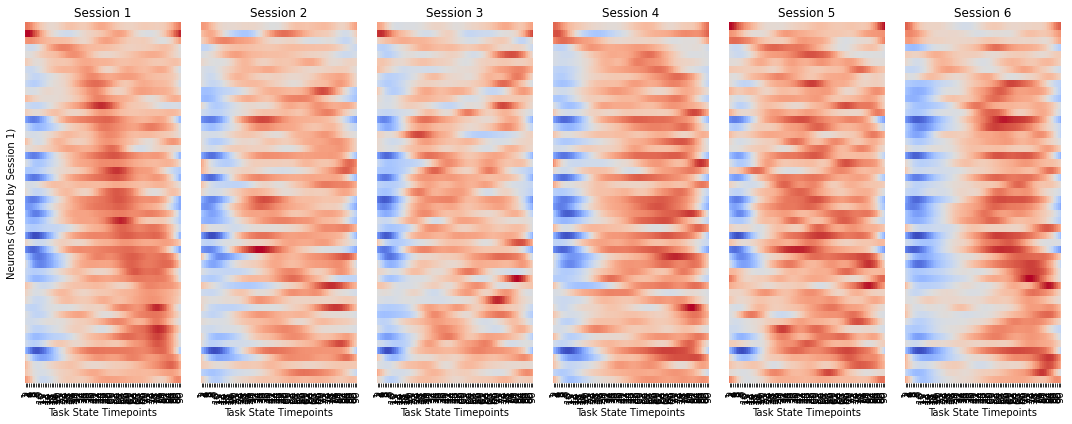

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def circular_smooth(data, sigma=5):
    """
    Smooths a 1D array while respecting its circularity.

    Parameters:
    - data: np.ndarray
        The input array of shape (timepoints,).
    - sigma: float
        The standard deviation for Gaussian smoothing.

    Returns:
    - smoothed_data: np.ndarray
        The smoothed array of the same length as the input.
    """
    extended_data = np.concatenate([data, data, data])
    smoothed_extended = gaussian_filter1d(extended_data, sigma=sigma)
    original_length = len(data)
    smoothed_data = smoothed_extended[original_length:2 * original_length]
    return smoothed_data

# Example input: List of 3D arrays [neurons x trials x timepoints]
data = norm_neurons_list  # Replace with your actual list of 3D arrays
num_sessions = len(data)
sigma = 5  # Smoothing parameter

# Step 1: Calculate mean firing rate across trials for each timepoint
mean_across_trials = [np.mean(session, axis=1) for session in data]  # List of [neurons x timepoints]

# Step 2: Z-score each neuron's firing rate within its session
z_scored_data = [((session - np.mean(session, axis=1, keepdims=True)) /
                  np.std(session, axis=1, keepdims=True)) for session in mean_across_trials]

# Step 3: Apply circular smoothing to z-scored data
smoothed_data = [np.array([circular_smooth(neuron_data, sigma=sigma) for neuron_data in session])
                 for session in z_scored_data]

# Step 4: Reshape into task-state averages (neurons x 90)
task_state_averages = [np.mean(session.reshape(session.shape[0], 4, 90), axis=1) for session in smoothed_data]

# Step 5: Sort neurons in the first session by peak firing rate
first_session = task_state_averages[0]
peak_values = np.max(first_session, axis=1)  # Peak firing rate for each neuron
peak_indices = np.argmax(first_session, axis=1)  # Index of peak for each neuron

# Sort by peak value, breaking ties with the peak index
sorting_order = np.lexsort((-peak_values, peak_indices))  # Sort by peak value (descending), then index
print(sorting_order)
# Apply sorting to all sessions
sorted_task_state_averages = [session[sorting_order] for session in task_state_averages]

# Debugging: Check if sorting is consistent
sorted_first_session = sorted_task_state_averages[0]
# assert np.all(np.diff(np.max(sorted_first_session, axis=1)) <= 0), "Sorting failed: Peaks are not descending."

# Step 6: Plot using Seaborn
fig, axes = plt.subplots(1, num_sessions-1, figsize=(15, 6), sharey=True)

for i, session in enumerate(sorted_task_state_averages[:-1]):
    ax = axes[i]
    sns.heatmap(
        session,
        cmap="coolwarm",
        ax=ax,
        cbar=i == num_sessions - 1,  # Show colorbar only on the last plot
        xticklabels=range(1, 91),
        yticklabels=False,
    )
    ax.set_title(f"Session {i + 1}")
    ax.set_xlabel("Task State Timepoints")
    if i == 0:
        ax.set_ylabel("Neurons (Sorted by Session 1)")

plt.tight_layout()
plt.show()



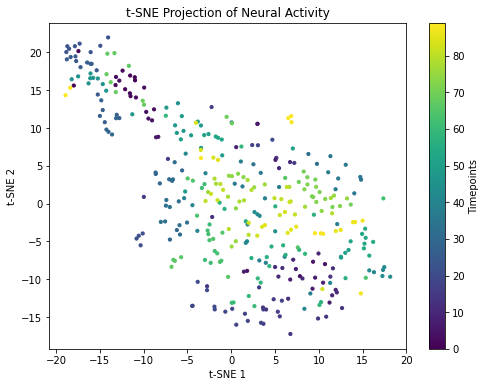

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
data = norm_neurons_list  # Replace with your actual list of 3D arrays
num_sessions = len(data)
sigma = 5  # Smoothing parameter

# Step 1: Calculate mean firing rate across trials for each timepoint
mean_across_trials = [np.mean(session, axis=1) for session in data]  # List of [neurons x timepoints]

session_1_data = mean_across_trials[0]
scaler = StandardScaler()
data_for_tsne = scaler.fit_transform(session_1_data)
# Initialize UMAP: 2D or 3D embedding
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)

# Perform t-SNE
tsne_results = tsne.fit_transform(data_for_tsne.T)  # Shape: (500, 2)

# Step 3: Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=np.repeat(np.arange(90), 4), cmap='viridis', s=10)
plt.colorbar(label='Timepoints')
plt.title('t-SNE Projection of Neural Activity')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [1]:
xx = [(1,2,3),(4,5,6)]

(1,2,3) in xx

True

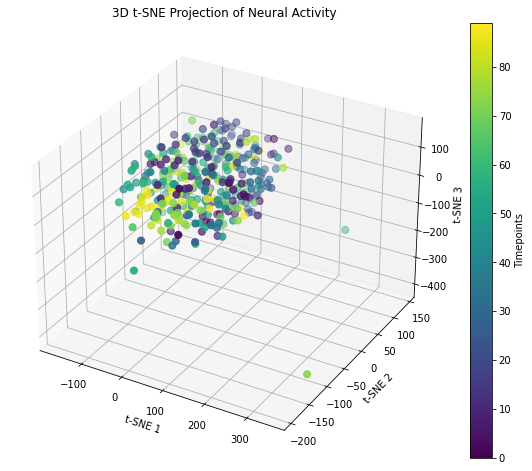

In [41]:
%matplotlib inline
tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)

# Perform t-SNE
tsne_results = tsne.fit_transform(data_for_tsne.T)  # Shape: (500, 3)

# Step 3: Visualize in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot: Color points by time (or any label if available)
sc = ax.scatter(
    tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2],
    c=np.repeat(np.arange(90), 4),  # Example: color by timepoints
    cmap='viridis', s=50
)

# Add colorbar and labels
cbar = plt.colorbar(sc)
cbar.set_label('Timepoints')
ax.set_title('3D t-SNE Projection of Neural Activity')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')

plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [13:44<00:00, 137.33s/it]


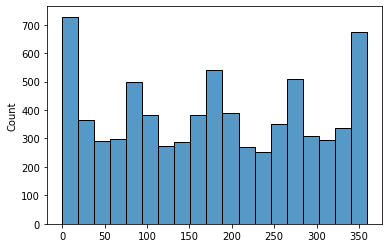

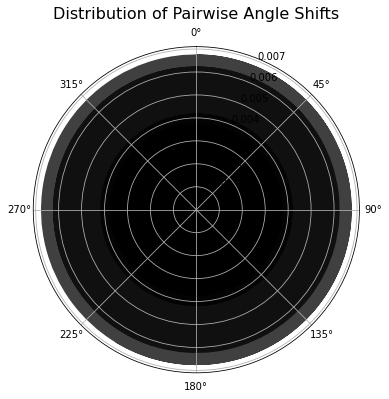

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# def circular_correlation_angle(fr1, fr2):
#     """
#     Compute the angle that maximizes correlation between fr1 and fr2 by circularly shifting fr2.
#     fr1 and fr2 are 1D arrays of equal length.
    
#     Returns:
#         angle_in_degrees: The shift (in degrees) at which the correlation is maximized.
#     """
#     length = len(fr1)
#     # Ensure mean subtraction or z-scoring might help reduce bias
#     fr1 = (fr1 - np.mean(fr1)) / (np.std(fr1) + 1e-9)
#     fr2 = (fr2 - np.mean(fr2)) / (np.std(fr2) + 1e-9)
    
#     # Test all possible shifts
#     correlations = []
#     for shift in range(length):
#         # Circular shift fr2 by 'shift' bins
#         fr2_shifted = np.roll(fr2, shift)
#         # Compute correlation
#         corr = np.corrcoef(fr1, fr2_shifted)[0,1]
#         correlations.append(corr)
    
#     # Find shift with maximum correlation
#     best_shift = np.argmax(correlations)
#     # Convert shift to degrees
#     angle_in_degrees = (best_shift / length) * 360
#     return angle_in_degrees

def compute_remapping_angle(mean1, mean2):
    n_bins = len(mean1)
    angles = np.arange(n_bins) * (2 * np.pi / n_bins)  # Angles corresponding to each bin
    correlations = []
    for shift in range(n_bins):
        # Circularly shift mean1
        shifted_mean1 = np.roll(mean1, shift)
        # Compute correlation
        correlation = np.corrcoef(shifted_mean1, mean2)[0, 1]
        correlations.append(correlation)
    # Find the shift that maximizes the correlation
    best_shift = np.argmax(correlations)
    best_angle = angles[best_shift]
    return best_shift


# Example data: Replace these with your actual data arrays
from tqdm import tqdm
angle_shifts = []
for session1_idx in tqdm(range(n_sessions-1)):
    for session2_idx in range(session1_idx + 1, n_sessions-1):
        for i, n1 in enumerate(sig_neurons[:-1]):
            for j, n2 in enumerate(sig_neurons[i+1:]):
                # Get firing rates for these two neurons in session X
                mean1 = np.mean(norm_neurons_list[session1_idx][n1], axis=0)
                mean1 = mean1-np.mean(mean1)
                mean2 = np.mean(norm_neurons_list[session1_idx][n2], axis=0)
                mean2 = mean2-np.mean(mean2)
                angle1 = compute_remapping_angle(mean1, mean2)


                mean1 = np.mean(norm_neurons_list[session2_idx][n1], axis=0)
                mean1 = mean1-np.mean(mean1)
                mean2 = np.mean(norm_neurons_list[session2_idx][n2], axis=0)
                mean2 = mean2-np.mean(mean2)   
                angle2 = compute_remapping_angle(mean1, mean2)
                
                # Compute the difference in their angles between sessions
                angle_diff = (angle1 - angle2) % 360
                # angle_diff = (angle_diff + 180) % 360 - 180
                
                angle_shifts.append(angle_diff)

angle_shifts = np.array(angle_shifts)

# Convert to radians for polar plot
# angle_shifts_radians = np.deg2rad(angle_shifts)
# sns.histplot(angle_shifts)
# # Plot polar histogram
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
# ax.hist(angle_shifts, bins=36, density=True, alpha=0.75, color='black')
# ax.set_title("Distribution of Pairwise Angle Shifts", va='bottom', fontsize=16)
# ax.set_theta_zero_location("N")
# ax.set_theta_direction(-1)

# plt.show()
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
# ax.hist(np.deg2rad(angle_shifts), bins=36, density=True, alpha=0.75, color='black')
# ax.set_title(r'$\phi - \psi$', va='bottom', fontsize=16)
# ax.set_theta_zero_location("N")
# ax.set_theta_direction(-1)

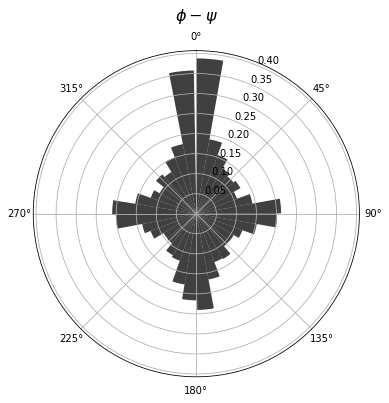

In [57]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.hist(np.deg2rad(angle_shifts), bins=36, density=True, alpha=0.75, color='black')
ax.set_title(r'$\phi - \psi$', va='bottom', fontsize=16)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

Bin counts: [2327 1678 1816 1619]
Observed Frequencies: [2327 1678 1816 1619]
Expected Frequencies: [1860 1860 1860 1860]
Chi-squared Value: 78.6709254792731
P-value: 5.916863845408158e-17


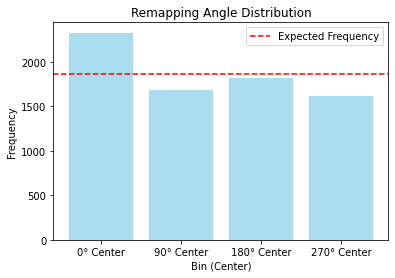

In [58]:
rotated_angles = (angle_shifts + 45) % 360

# Step 3: Define bin edges for 4 bins: 0-90, 90-180, 180-270, 270-360
bin_edges = np.array([0, 90, 180, 270, 360])
bin_labels = ["0° Center", "90° Center", "180° Center", "270° Center"]
# Step 4: Use np.digitize to assign each rotated angle to a bin
bins = np.digitize(rotated_angles, bins=bin_edges, right=False)

# Step 5: Adjust the bin numbers (the digitize function returns bin indices starting from 1)
bins = bins - 1  # Adjust to make bin indices start from 0

# Step 6: Calculate frequencies of remapping angles in each bin
observed_frequencies = np.bincount(bins, minlength=4)

# Output the results
print("Bin counts:", observed_frequencies)

# Step 6: Expected frequencies (uniform distribution)
expected_frequencies = np.full_like(observed_frequencies, len(rotated_angles) / 4)

# Step 7: Perform chi-squared test
chi2, p_value = chi2_contingency([observed_frequencies, expected_frequencies])[:2]

# Step 8: Print results
print(f"Observed Frequencies: {observed_frequencies}")
print(f"Expected Frequencies: {expected_frequencies}")
print(f"Chi-squared Value: {chi2}")
print(f"P-value: {p_value}")



plt.bar(bin_labels, observed_frequencies, color="skyblue", alpha=0.7)
plt.axhline(y=expected_frequencies[0], color="red", linestyle="--", label="Expected Frequency")
plt.xlabel("Bin (Center)")
plt.ylabel("Frequency")
plt.title("Remapping Angle Distribution")
plt.legend()
plt.show()


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [15:07<00:00, 151.24s/it]


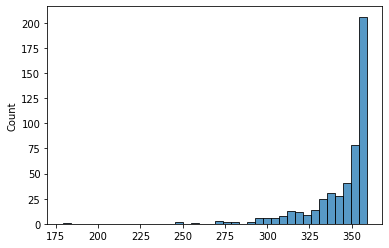

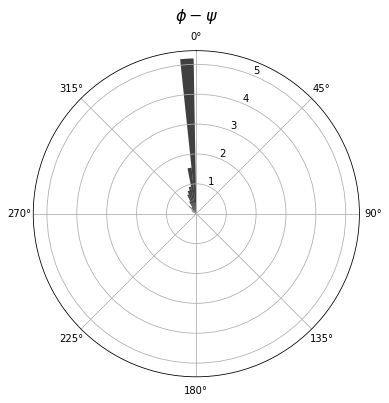

In [61]:
from collections import defaultdict
pair_angles = defaultdict(list)
for session1_idx in tqdm(range(n_sessions-1)):
    for session2_idx in range(session1_idx + 1, n_sessions-1):
        for i, n1 in enumerate(sig_neurons[:-1]):
            for j, n2 in enumerate(sig_neurons[i+1:]):
                # Get firing rates for these two neurons in session X
                mean1 = np.mean(norm_neurons_list[session1_idx][n1], axis=0)
                mean1 = mean1-np.mean(mean1)
                mean2 = np.mean(norm_neurons_list[session1_idx][n2], axis=0)
                mean2 = mean2-np.mean(mean2)
                angle1 = compute_remapping_angle(mean1, mean2)


                mean1 = np.mean(norm_neurons_list[session2_idx][n1], axis=0)
                mean1 = mean1-np.mean(mean1)
                mean2 = np.mean(norm_neurons_list[session2_idx][n2], axis=0)
                mean2 = mean2-np.mean(mean2)   
                angle2 = compute_remapping_angle(mean1, mean2)
                
                # Compute the difference in their angles between sessions
                angle_diff = (angle1 - angle2) % 360
                # angle_diff = (angle_diff + 180) % 360 - 180
        
                pair_key = (n1, n2)
                pair_angles[pair_key].append(angle_diff)

max_angle_diff_per_pair = {pair: max(angles) for pair, angles in pair_angles.items()}
arr = np.array(list(max_angle_diff_per_pair.values()))
# Convert to radians for polar plot
# angle_shifts_radians = np.deg2rad(angle_shifts)
sns.histplot(arr)
# Plot polar histogram
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.hist(np.deg2rad(arr), bins=36, density=True, alpha=0.75, color='black')
ax.set_title(r'$\phi - \psi$', va='bottom', fontsize=16)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

plt.show()



# Now pair_angles contains a list of angle differences for each neuron pair.
# Take the maximum angle difference for each pair.
max_angle_diff_per_pair = {pair: max(angles) for pair, angles in pair_angles.items()}

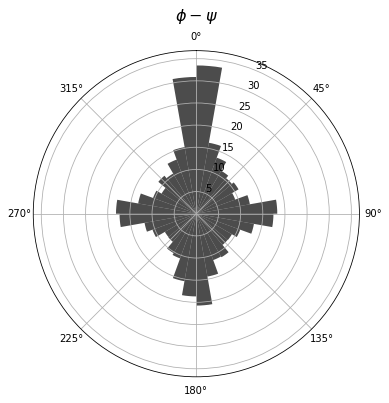

In [67]:
n_session_pairs = len(pair_angles[(5, 6)])
session_pair_angle_diffs = [[] for _ in range(n_session_pairs)]

for (n1, n2), angles_list in pair_angles.items():
    for k, angle in enumerate(angles_list):
        session_pair_angle_diffs[k].append(angle)

bins = np.linspace(0, 360, 37)

histograms = []
for angle_list in session_pair_angle_diffs:
    counts, _ = np.histogram(angle_list, bins=bins)
    histograms.append(counts)

histograms_array = np.array(histograms)  # shape: (n_session_pairs, number_of_bins-1)
average_hist = np.mean(histograms_array, axis=0)

bin_centers_degrees = 0.5 * (bins[:-1] + bins[1:])
bin_centers_radians = np.deg2rad(bin_centers_degrees)

# The width of each bin in radians
bin_width = np.deg2rad(bins[1] - bins[0])

# Create a polar subplot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8,6))

# Plot using a bar plot in polar coordinates
# theta is bin_centers_radians, height is average_hist
bars = ax.bar(bin_centers_radians, average_hist, width=bin_width, bottom=0.0, alpha=0.7, color='black', edgecolor='none')

# Customize the plot
ax.set_theta_zero_location("N")  # Set 0 degrees at the top (North)
ax.set_theta_direction(-1)       # Plot clockwise
ax.set_title(r'$\phi - \psi$', va='bottom', fontsize=16)
# Optional: adjust radial limits or add gridlines
ax.set_rlim(0, max(average_hist)*1.1)

plt.show()

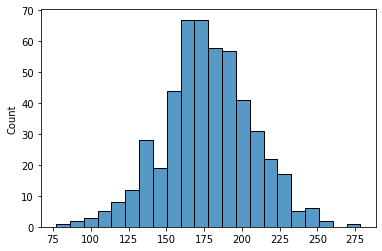

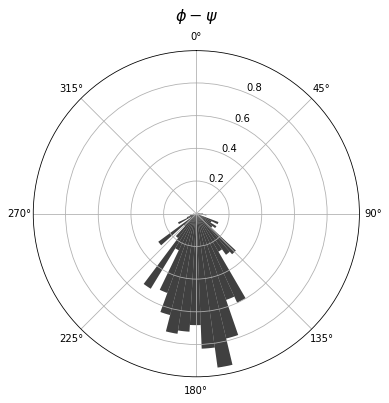

In [62]:
mean_angle_diff_per_pair = {pair: np.mean(angles) for pair, angles in pair_angles.items()}
arr = np.array(list(mean_angle_diff_per_pair.values()))
# Convert to radians for polar plot
# angle_shifts_radians = np.deg2rad(angle_shifts)
sns.histplot(arr)
# Plot polar histogram
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
ax.hist(np.deg2rad(arr), bins=36, density=True, alpha=0.75, color='black')
ax.set_title(r'$\phi - \psi$', va='bottom', fontsize=16)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

plt.show()

In [ ]:
norm_neurons_list[0].shape


(50, 22, 360)

# Decoding Analysis


In [81]:
task_norm_neurons_list = norm_neurons_list[:-1]
session_data = task_norm_neurons_list


In [82]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Assume session_data is a list of length 6, each element is (num_neurons, num_trials, 360)
# session_data[i] is for session i

num_sessions = len(session_data)
assert num_sessions == 6, "We expect exactly 6 sessions in session_data."

# We know that states A, B, C, D each span 90 bins
state_bins = [(0,90), (90,180), (180,270), (270,360)]
state_labels = ['A', 'B', 'C', 'D']

def assign_state_labels(num_timebins=360):
    """Create a label array of length num_timebins indicating which state each bin belongs to."""
    labels = np.empty(num_timebins, dtype=object)
    for state_idx, (start, end) in enumerate(state_bins):
        labels[start:end] = state_labels[state_idx]
    return labels

timebin_labels = assign_state_labels(360)

# A helper function to reshape data into samples and labels
def prepare_data_for_decoding(session_array):
    """
    session_array: shape (num_neurons, num_trials, 360)
    We will return:
    X: shape (num_trials * 360, num_neurons)
    y: shape (num_trials * 360,)
    """
    num_neurons, num_trials, num_timebins = session_array.shape
    # Flatten trials and timebins
    # We want (trial * timebin) samples each of length num_neurons
    X = session_array.transpose(1, 2, 0).reshape(num_trials*num_timebins, num_neurons)
    # Labels repeat for each trial
    y = np.tile(timebin_labels, num_trials)
    return X, y

# Cross-validation over sessions
accuracies = []

for held_out_session_idx in range(num_sessions):
    # Prepare training data (all sessions except the held_out)
    train_sessions = [i for i in range(num_sessions) if i != held_out_session_idx]
    
    X_train_list = []
    y_train_list = []
    
    for s in train_sessions:
        X_tmp, y_tmp = prepare_data_for_decoding(session_data[s])
        X_train_list.append(X_tmp)
        y_train_list.append(y_tmp)
        
    X_train = np.vstack(X_train_list)
    y_train = np.hstack(y_train_list)
    
    # Prepare test data
    X_test, y_test = prepare_data_for_decoding(session_data[held_out_session_idx])
    
    # Optional: scale data (important for SVM)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train SVM decoder
    # You may want to tune C, kernel, etc.
    clf = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42)
    clf.fit(X_train_scaled, y_train)
    
    # Evaluate on test
    acc = clf.score(X_test_scaled, y_test)
    accuracies.append(acc)
    print(f"Held-out session {held_out_session_idx}: Accuracy = {acc:.3f}")

# Compute the mean accuracy over all folds
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
print(f"Cross-validated decoding accuracy: {mean_accuracy:.3f} ± {std_accuracy:.3f}")



Held-out session 0: Accuracy = 0.257
Held-out session 1: Accuracy = 0.287
Held-out session 2: Accuracy = 0.283
Held-out session 3: Accuracy = 0.225
Held-out session 4: Accuracy = 0.284
Held-out session 5: Accuracy = 0.281
Cross-validated decoding accuracy: 0.269 ± 0.022


In [83]:
from sklearn import svm

# Cross-validation over sessions
accuracies = []

for held_out_session_idx in range(num_sessions):
    # Prepare training data (all sessions except the held_out)
    train_sessions = [i for i in range(num_sessions) if i != held_out_session_idx]
    
    X_train_list = []
    y_train_list = []
    
    for s in train_sessions:
        X_tmp, y_tmp = prepare_data_for_decoding(session_data[s])
        X_train_list.append(X_tmp)
        y_train_list.append(y_tmp)
        
    X_train = np.vstack(X_train_list)
    y_train = np.hstack(y_train_list)
    
    # Prepare test data
    X_test, y_test = prepare_data_for_decoding(session_data[held_out_session_idx])
    
    # Optional: scale data (important for SVM)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train SVM decoder
    # You may want to tune C, kernel, etc.
    clf = svm.NuSVC(gamma="auto")
    clf.fit(X_train_scaled, y_train)
    
    # Evaluate on test
    acc = clf.score(X_test_scaled, y_test)
    accuracies.append(acc)
    print(f"Held-out session {held_out_session_idx}: Accuracy = {acc:.3f}")

# Compute the mean accuracy over all folds
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
print(f"Cross-validated decoding accuracy: {mean_accuracy:.3f} ± {std_accuracy:.3f}")



Held-out session 0: Accuracy = 0.268
Held-out session 1: Accuracy = 0.288
Held-out session 2: Accuracy = 0.279
Held-out session 3: Accuracy = 0.240
Held-out session 4: Accuracy = 0.294
Held-out session 5: Accuracy = 0.265
Cross-validated decoding accuracy: 0.272 ± 0.018


In [86]:
X_test.shape
y_test.shape

(10440,)

In [ ]:
y_test

In [87]:
y_test

array(['A', 'A', 'A', ..., 'D', 'D', 'D'], dtype=object)